# Loyola Supply Chain Data Analysis Competition

## Contributers:

    Aarij Rehman
    Charlie Marshall

## Loading Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## Loading in Data (Charlie):

Aarij will have to use different directories for his data.

In [2]:
FreightWaves=pd.read_excel("/Users/charlesmarshall/Desktop/Loyola-Supply-Chain-Competition/FreightWaves External Data.xlsx")

In [3]:
ShipperData=pd.read_excel("/Users/charlesmarshall/Desktop/Loyola-Supply-Chain-Competition/Loyola 2nd Annual Data Competition - Shipper Data Set (Trailing 2-Years).xlsx")

In [4]:
#FreightWaves=pd.read_excel("/Users/aarij/Desktop/python-projects/loyola-supply-chain/FreightWaves External Data.xlsx")

In [5]:
#ShipperData=pd.read_excel("/Users/aarij/Desktop/python-projects/loyola-supply-chain/Loyola 2nd Annual Data Competition - Shipper Data Set (Trailing 2-Years).xlsx")

In [6]:
ShipperData.head()

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type
0,1046,2018-02-26,2018-02-26,2018-02-27,Atlanta,300,GA,NaN,217,MD,Temp Control,1316,Spot,1650.00,0,Ad-hoc
1,1223,2018-02-15,2018-02-16,2018-02-18,Chicago,463,IN,NaN,820,WY,Temp Control,1920,Spot,3480.00,0,Ad-hoc
2,1280,2018-02-15,2018-02-15,2018-02-19,Los Angeles,906,CA,NaN,554,MN,Dry Van,3816,Spot,3567.80,0,Ad-hoc
3,1282,2018-02-15,2018-02-16,2018-02-20,Chicago,601,IL,Chicago,606,IL,Dry Van,48,Spot,203.35,-42,Ad-hoc
4,1340,2018-02-16,2018-02-19,2018-02-19,Chicago,606,IL,Chicago,607,IL,Dry Van,42,Spot,343.88,0,Dedicated


## EDA

Understanding the data:

In [7]:
ShipperData['Book Date']=pd.to_datetime(ShipperData['Book Date'])
ShipperData['Pickup Date']=pd.to_datetime(ShipperData['Pickup Date'])
ShipperData['Delivery Date']=pd.to_datetime(ShipperData['Delivery Date'])

In [8]:
set(ShipperData['Origin Market'])

{'Atlanta', 'Chicago', 'Dallas', 'Los Angeles', 'Philadelphia', 'Seattle'}

In [9]:
set(ShipperData['Mode'])

{'Air',
 'Drayage',
 'Dry Van',
 'FlatBed',
 'Intermodal',
 'Ocean',
 'Other',
 'Reefer',
 'Temp Control',
 'Truck'}

In [10]:
set(ShipperData['Spot/Contract'])

{'Contract', 'Spot'}

In [11]:
set(ShipperData['Load Type'])

{'Ad-hoc', 'Consistent', 'Critical', 'Dedicated', 'Standard', 'White Glove'}

In [12]:
set(FreightWaves['index_name'])

{'DAT Longhaul Van Freight Rate',
 'Diesel Truck Stop Actual Price Per Gallon',
 'Headhaul Index',
 'Industrial Production',
 'Institute of Supply Management Metrics',
 'Intermodal Rates',
 'Orders',
 "Outbound Rail Volume 53' Containers (Loaded)",
 'Outbound Tender Reject Index',
 'Outbound Tender Volume Index',
 'Producer Price Index',
 'Retail Sales YoY Change',
 'TLT is now a legacy variable, refer to OTLT',
 'Total Construction Spending (000,000s)',
 'US Customs Maritime Import Shipments'}

## Preprocessing

Some preproccessing that needs to be done to the whole data set

### 7 FreightWaves Futures Lanes:
    VLS (LA -> Seattle)
    VSL (Seattle -> LA)
    VLD (LA -> Dallas)
    VDL (Dallas -> LA)
    VCA (Chicago -> Atlanta)
    VAP (Atlanta -> Philadelphia)
    VPC (Philadelphia -> Chicago)
    
    If the load is not delivered in one of these lanes, it will be marked 'Other'

In [13]:
# Categorizing the Future Lanes
Lane = []
org = list(ShipperData['Origin Market'])
dst = list(ShipperData['Dest Market'])
los = 'Los Angeles'
sea = 'Seattle'
dal = 'Dallas'
chi = 'Chicago'
atl = 'Atlanta'
phi = 'Philadelphia'

futures = {}
futures[(los, sea)] = 'VLS'
futures[(sea, los)] = 'VSL'
futures[(los, dal)] = 'VLD'
futures[(dal, los)] = 'VDL'
futures[(chi, atl)] = 'VCA'
futures[(atl, phi)] = 'VAP'
futures[(phi, chi)] = 'VPC'

In [14]:
Lane=[]
for i in range(len(org)):
    if (org[i], dst[i]) in futures:
        Lane.append(futures[(org[i], dst[i])])
    else:
        Lane.append('Other')

In [15]:
ShipperData['Lane'] = Lane

In [16]:
ShipperData.head()

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane
0,1046,2018-02-26,2018-02-26,2018-02-27,Atlanta,300,GA,NaN,217,MD,Temp Control,1316,Spot,1650.00,0,Ad-hoc,Other
1,1223,2018-02-15,2018-02-16,2018-02-18,Chicago,463,IN,NaN,820,WY,Temp Control,1920,Spot,3480.00,0,Ad-hoc,Other
2,1280,2018-02-15,2018-02-15,2018-02-19,Los Angeles,906,CA,NaN,554,MN,Dry Van,3816,Spot,3567.80,0,Ad-hoc,Other
3,1282,2018-02-15,2018-02-16,2018-02-20,Chicago,601,IL,Chicago,606,IL,Dry Van,48,Spot,203.35,-42,Ad-hoc,Other
4,1340,2018-02-16,2018-02-19,2018-02-19,Chicago,606,IL,Chicago,607,IL,Dry Van,42,Spot,343.88,0,Dedicated,Other


### Rate per Mile

    Calculating the Rate per Mile (RPM) for all loads

In [17]:
rpm=np.empty(len(ShipperData))

In [18]:
for i in range(len(ShipperData)):
    if ShipperData['Mileage'][i]==0:
        rpm[i]=0
    else:
        try:
            rpm[i]= ShipperData['Revenue'][i]/ShipperData['Mileage'][i]
        except TypeError:
            rpm[i]=0

In [19]:
ShipperData['RPM'] = rpm

## Questions to Ask:

#### Part 1    
    1) Does 2019 mean the book, pickup, or delivery date is in 2019? There are many times when the one of these three meaures are in another year while other measures are in 2019.
    - Something to think about: when the deal is booked is when the rate is agreed, so it might be more appropriate to do year by book date.
    2) When you say "Truckload" RPM", does this mean only for trucks and dry vans?
    3) How should we deal with instances where the mileage is 0 or blank? Outlier
    4) How would you define "volatility"? Does it have something to do with spot vs contract market prices and how they change? Maybe the spread of the prices?

## Question 1

    Calculating overall average Truckload rate per mile in 2019?  Hint: rate per mile is total revenue for a move divided by total mileage.  Please also note that “Dry Van” and “Truck” mean the same thing here:

    Steps:
    Year = 2019
    Truckload = "Dry Van" or "Truck" in Mode ??? NOT SURE IF "TRUCKLOAD" MEANS JUST THESE TWO ANYMORE ???
    Create column of Rate per mile (RPM), divide revenue by mileage for each truckload
    Sum the RPM column, divide by number of instances to find AVERAGE
    

### Converting all date columns to datetime

In [20]:
Shipper2019=ShipperData[ShipperData['Pickup Date'].dt.year == 2019]

In [21]:
Shipper2019.head()

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane,RPM
2492,147769,2018-12-31,2019-01-02,2019-01-04,Atlanta,310,GA,NaN,782,TX,Dry Van,2218,Spot,1836.00,0,Ad-hoc,Other,0.827773
2532,147889,2018-12-19,2019-01-02,2019-01-11,Los Angeles,902,CA,NaN,482,MI,Intermodal,4600,Spot,4340.00,0,Ad-hoc,Other,0.943478
2588,155164,2019-01-03,2019-01-05,2019-01-07,Chicago,609,IL,NaN,404,KY,Dry Van,764,Spot,1266.34,0,Consistent,Other,1.657513
2589,155166,2019-01-08,2019-01-08,2019-01-10,Chicago,606,IL,NaN,154,MA,Dry Van,1898,Spot,2895.15,-11,Ad-hoc,Other,1.525369
2590,155169,2019-01-03,2019-01-05,2019-01-07,Chicago,609,IL,NaN,404,KY,Dry Van,764,Spot,1266.34,0,Consistent,Other,1.657513


In [22]:
Q1=Shipper2019[Shipper2019['Mode'].isin(['Dry Van','Truck'])].copy()

In [23]:
Q1=Q1.reset_index(drop=True)

In [24]:
Q1[Q1['Mileage']==0].head()

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane,RPM
39,155407,2019-01-04,2019-01-04,2019-01-07,Chicago,608,IL,Chicago,608,IL,Dry Van,0,Spot,250.54,-5,Dedicated,Other,0.0
61,138663,2019-01-02,2019-01-02,2019-01-31,Chicago,605,IL,Chicago,605,IL,Dry Van,0,Spot,450.00,450,Ad-hoc,Other,0.0
62,138664,2019-01-02,2019-01-02,2019-01-31,Chicago,605,IL,Chicago,605,IL,Dry Van,0,Spot,450.00,450,Ad-hoc,Other,0.0
64,141319,2019-01-03,2019-01-06,2019-02-06,Chicago,605,IL,Chicago,605,IL,Dry Van,0,Spot,575.00,575,Ad-hoc,Other,0.0
65,141320,2019-01-03,2019-01-06,2019-02-06,Chicago,605,IL,Chicago,605,IL,Dry Van,0,Spot,450.00,450,Ad-hoc,Other,0.0


In [25]:
Q1[Q1['Revenue']==0].head()

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane,RPM
240,152630,2019-03-04,2019-01-02,2019-01-03,Los Angeles,917,CA,NaN,953,CA,Dry Van,(blank),Spot,0.0,0,Ad-hoc,Other,0.0
421,154220,2019-01-02,2019-01-02,2019-01-02,Chicago,600,IL,Chicago,601,IL,Dry Van,44,Spot,0.0,0,Ad-hoc,Other,0.0
422,154222,2019-01-02,2019-01-03,2019-01-03,Chicago,600,IL,Chicago,601,IL,Dry Van,44,Spot,0.0,0,Ad-hoc,Other,0.0
423,154224,2019-01-02,2019-01-04,2019-01-04,Chicago,600,IL,Chicago,601,IL,Dry Van,44,Spot,0.0,0,Ad-hoc,Other,0.0
425,154256,2019-01-02,2019-01-02,2019-01-02,Chicago,601,IL,Chicago,601,IL,Dry Van,0,Spot,0.0,-1,Ad-hoc,Other,0.0


In [26]:
Average2019RPM=sum(Q1['RPM'])/len(Q1)

In [27]:
Average2019RPM

3.605813503312686

### Question 1a

    Using this Redwood rate per mile data, rank the 7 FreightWaves Futures lanes (page 2 at link) by rate volatility for full year 2019.
    
    Volatility = sd
    So, the Futures lanes will be ranked by sd of RPM data. Highest to lowest.

In [28]:
LaneVolitility2019=pd.DataFrame(Q1.groupby('Lane')['RPM'].std(),columns=['RPM']).drop(['Other']).sort_values(by=['RPM'],ascending=False)

In [29]:
LaneVolitility2019

,RPM
Lane,
VPC,5.410751
VCA,1.275223
VLS,0.789660
VAP,0.625256
VLD,0.552769
VDL,0.357352
VSL,0.296679


### Question 1b

    Rank these lanes by total Redwood Truckload volume for full year 2019.
    
    Defining "volume" as the number (count) of truckloads delivered in each lane in 2019.

In [30]:
LaneVolume2019=pd.DataFrame(Q1.groupby('Lane')['RPM'].count()).drop(['Other']).sort_values(by=['RPM'],ascending=False).rename(columns={'RPM':'Volume'})

In [31]:
LaneVolume2019

,Volume
Lane,
VCA,396
VSL,275
VDL,198
VPC,197
VLS,174
VLD,107
VAP,40


In [32]:
Shipper2019['Lane'].value_counts()

Other    48923
VCA        480
VSL        291
VDL        258
VPC        230
VLS        187
VLD        136
VAP         42
Name: Lane, dtype: int64

## Question 2

    Rank the lanes provided in the FreightWaves data by total intermodal volume for full year 2019.

In [33]:
Q2=Shipper2019[Shipper2019['Mode'].isin(['Intermodal'])]

In [34]:
Q2=Q2.reset_index(drop=True)

In [35]:
IntermodalLaneVolume2019=pd.DataFrame(Q2.groupby('Lane')['Load Number'].count()).drop(['Other']).sort_values(by=['Load Number'],ascending=False).rename(columns={'RPM':'Volume'})

In [36]:
IntermodalLaneVolume2019

,Load Number
Lane,
VDL,47
VLD,29
VCA,1


## Question 3

    Graph monthly volatility in fuel prices by markets provided in the FreightWaves data.  Do any markets stand out to you in particular?

In [37]:
FreightWaves['data_timestamp']=pd.to_datetime(FreightWaves['data_timestamp'])

In [38]:
FreightWaves.head()

,ticker,granularity1,symbol,data_timestamp,data_value,index_name,Description
0,COSP,RES,COSP.RES,2019-04-30,512113.0,"Total Construction Spending (000,000s)",Residential
1,COSP,RES,COSP.RES,2019-09-30,529455.0,"Total Construction Spending (000,000s)",Residential
2,COSP,RES,COSP.RES,2019-11-30,540457.0,"Total Construction Spending (000,000s)",Residential
3,COSP,RES,COSP.RES,2018-02-28,577315.0,"Total Construction Spending (000,000s)",Residential
4,COSP,RES,COSP.RES,2018-12-31,517951.0,"Total Construction Spending (000,000s)",Residential


In [39]:
set(FreightWaves['ticker'])

{'COSP',
 'CSTM',
 'DATVF',
 'DTS',
 'HAUL',
 'INTRM',
 'IPRO',
 'ISM',
 'ORAIL53L',
 'ORDERS',
 'OTRI',
 'OTVI',
 'PPI',
 'RESLG',
 'TLT'}

In [40]:
Q3=FreightWaves[FreightWaves['ticker']=='DTS']

In [41]:
Q3=Q3.reset_index(drop=True)

In [42]:
Q3.head()

,ticker,granularity1,symbol,data_timestamp,data_value,index_name,Description
0,DTS,ATL,DTS.ATL,2018-03-13,2.777,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"
1,DTS,ATL,DTS.ATL,2018-03-16,2.828,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"
2,DTS,ATL,DTS.ATL,2018-03-27,2.921,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"
3,DTS,ATL,DTS.ATL,2018-03-29,2.952,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"
4,DTS,ATL,DTS.ATL,2018-04-02,2.915,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"


In [43]:
set(Q3['Description'])

{'Atlanta, GA',
 'Chicago, IL',
 'Dallas, TX',
 'Los Angeles, CA',
 'Philadelphia, PA',
 'Seattle, WA'}

In [44]:
set(Q3['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [45]:
per = Q3.data_timestamp.dt.to_period("M")

In [46]:
DTS_Monthly_Volatility=Q3.groupby(['granularity1',per]).std()

In [47]:
DTS_Monthly_Volatility.head()

data_value
granularity1 data_timestamp            
ATL          2018-03           0.061742
             2018-04           0.047529
             2018-05           0.043612
             2018-06           0.053354
             2018-07           0.021432

In [48]:
months=['2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01','2020-02']
y_atl=DTS_Monthly_Volatility['data_value'][0:24]
y_chi=DTS_Monthly_Volatility['data_value'][24:48]
y_dal=DTS_Monthly_Volatility['data_value'][48:72]
y_lax=DTS_Monthly_Volatility['data_value'][72:96]
y_phl=DTS_Monthly_Volatility['data_value'][96:120]
y_sea=DTS_Monthly_Volatility['data_value'][120:144]

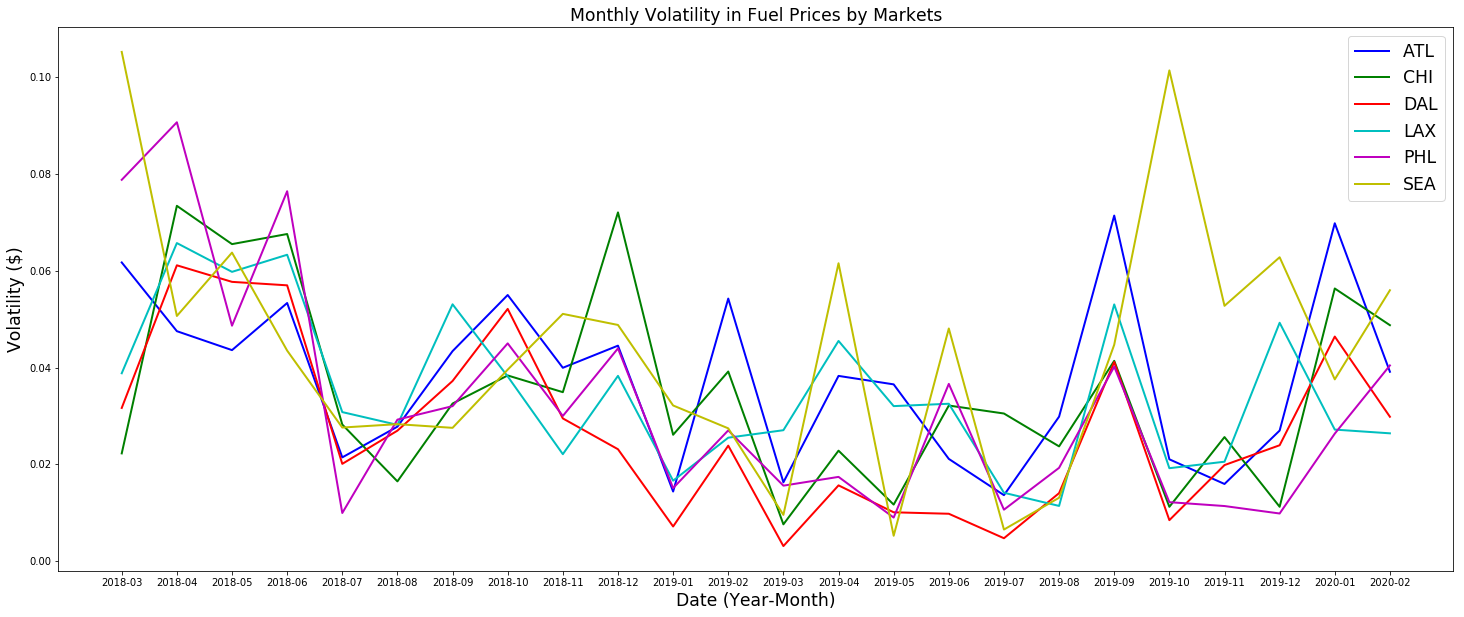

In [49]:
fig1 = plt.figure(figsize=(25,10))
plt.plot( months, y_atl, marker='', color='b', linewidth=2,label="ATL")
plt.plot( months, y_chi, marker='', color='g', linewidth=2,label="CHI")
plt.plot( months, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot( months, y_lax, marker='', color='c', linewidth=2,label="LAX")
plt.plot( months, y_phl, marker='', color='m', linewidth=2,label="PHL")
plt.plot( months, y_sea, marker='', color='y', linewidth=2,label="SEA")
plt.title('Monthly Volatility in Fuel Prices by Markets',fontsize='xx-large')
plt.ylabel('Volatility ($)',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')
plt.legend(fontsize='xx-large')

## Question 4

    Briefly explain how the mixture of spot and contract (% of total volume) of Dry-Van freight in the Redwood Data varied throughout 2018-2019.  What factors do you think would cause a shipper to sign a forward-looking Truckload rate contract or rely on the spot market?

In [50]:
Shipper2019 = ShipperData[(ShipperData['Pickup Date'].dt.year == 2019) & (ShipperData['Mode'].isin(['Dry Van', 'Truck']))]
Shipper2018 = ShipperData[(ShipperData['Pickup Date'].dt.year == 2018) & (ShipperData['Mode'].isin(['Dry Van', 'Truck']))]

In [51]:
spot18 = []
spot19 = []
for month in range(1, 13):
    spot18.append(Shipper2018[Shipper2018['Pickup Date'].dt.month == month]['Spot/Contract'].value_counts(normalize=True)['Spot'])
    spot19.append(Shipper2019[Shipper2019['Pickup Date'].dt.month == month]['Spot/Contract'].value_counts(normalize=True)['Spot'])
spot = spot18 + spot19

In [52]:
cont = [1-i for i in spot]

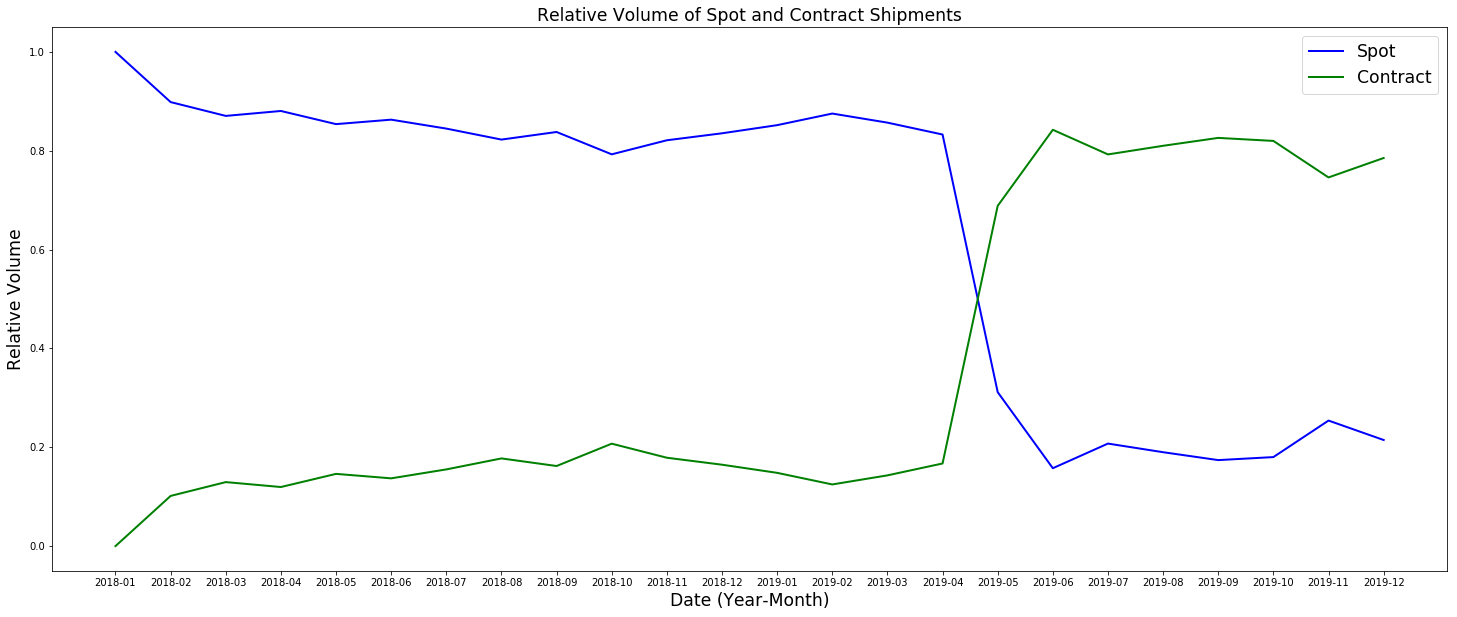

In [53]:
months=['2018-01', '2018-02', '2018-03', '2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig = plt.figure(figsize=(25,10))
plt.plot(months, spot, marker='', color='b', linewidth=2,label="Spot")
plt.plot(months, cont, marker='', color='g', linewidth=2,label="Contract")

plt.title('Relative Volume of Spot and Contract Shipments',fontsize='xx-large')
plt.ylabel('Relative Volume',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')
plt.legend(fontsize='xx-large')

## Question 5

    Based on initial analysis, please list and explain the (3) “external factors” from the FreightWaves data you think look the most promising for predicting 2020 dry van shipper rates as a Shipper.  

In [54]:
Q5=ShipperData[ShipperData['Mode'].isin(['Dry Van','Truck'])]

In [55]:
Q5=Q5.reset_index(drop=True)

In [56]:
Q5.head()

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane,RPM
0,1280,2018-02-15,2018-02-15,2018-02-19,Los Angeles,906,CA,NaN,554,MN,Dry Van,3816,Spot,3567.80,0,Ad-hoc,Other,0.934958
1,1282,2018-02-15,2018-02-16,2018-02-20,Chicago,601,IL,Chicago,606,IL,Dry Van,48,Spot,203.35,-42,Ad-hoc,Other,4.236458
2,1340,2018-02-16,2018-02-19,2018-02-19,Chicago,606,IL,Chicago,607,IL,Dry Van,42,Spot,343.88,0,Dedicated,Other,8.187619
3,1397,2018-02-19,2018-02-22,2018-02-22,Dallas,761,TX,Dallas,761,TX,Dry Van,60,Spot,311.47,0,Consistent,Other,5.191167
4,1398,2018-02-21,2018-02-22,2018-02-22,Dallas,761,TX,Dallas,761,TX,Dry Van,60,Spot,311.47,0,Ad-hoc,Other,5.191167


In [57]:
FreightWaves.head()

,ticker,granularity1,symbol,data_timestamp,data_value,index_name,Description
0,COSP,RES,COSP.RES,2019-04-30,512113.0,"Total Construction Spending (000,000s)",Residential
1,COSP,RES,COSP.RES,2019-09-30,529455.0,"Total Construction Spending (000,000s)",Residential
2,COSP,RES,COSP.RES,2019-11-30,540457.0,"Total Construction Spending (000,000s)",Residential
3,COSP,RES,COSP.RES,2018-02-28,577315.0,"Total Construction Spending (000,000s)",Residential
4,COSP,RES,COSP.RES,2018-12-31,517951.0,"Total Construction Spending (000,000s)",Residential


### Feature Engineering

    Task is to find the features in the Freight Waves data that are best at predicting RPM in 2020. The tricky part is how to represent each of these features.

### Potential Features:

    1) Past "performance" of indecies
        - past month should be used because it is improper to use future data to predict current performance. For instance, you can use a current monthly average to train the data on, but when predicting on future data, there will be no way to calculate the average for a current month because the month is not yet over.
        - what period of time is relevant? this most likely changes based on the index but multiple time periods should be explored.
    2) Comparing Y2Y rates might also be smart.

### EDA

Exploring each of the indecies to better understand them and how they should be utilized in a model.

In [58]:
set(FreightWaves['index_name'])

{'DAT Longhaul Van Freight Rate',
 'Diesel Truck Stop Actual Price Per Gallon',
 'Headhaul Index',
 'Industrial Production',
 'Institute of Supply Management Metrics',
 'Intermodal Rates',
 'Orders',
 "Outbound Rail Volume 53' Containers (Loaded)",
 'Outbound Tender Reject Index',
 'Outbound Tender Volume Index',
 'Producer Price Index',
 'Retail Sales YoY Change',
 'TLT is now a legacy variable, refer to OTLT',
 'Total Construction Spending (000,000s)',
 'US Customs Maritime Import Shipments'}

In [59]:
set(FreightWaves['ticker'])

{'COSP',
 'CSTM',
 'DATVF',
 'DTS',
 'HAUL',
 'INTRM',
 'IPRO',
 'ISM',
 'ORAIL53L',
 'ORDERS',
 'OTRI',
 'OTVI',
 'PPI',
 'RESLG',
 'TLT'}

### COSP

In [60]:
COSP=FreightWaves[FreightWaves['ticker']=='COSP']

In [61]:
COSP=COSP.sort_values(by='data_timestamp').reset_index(drop=True)

Text(0.5, 0, 'Date (Year-Month)')

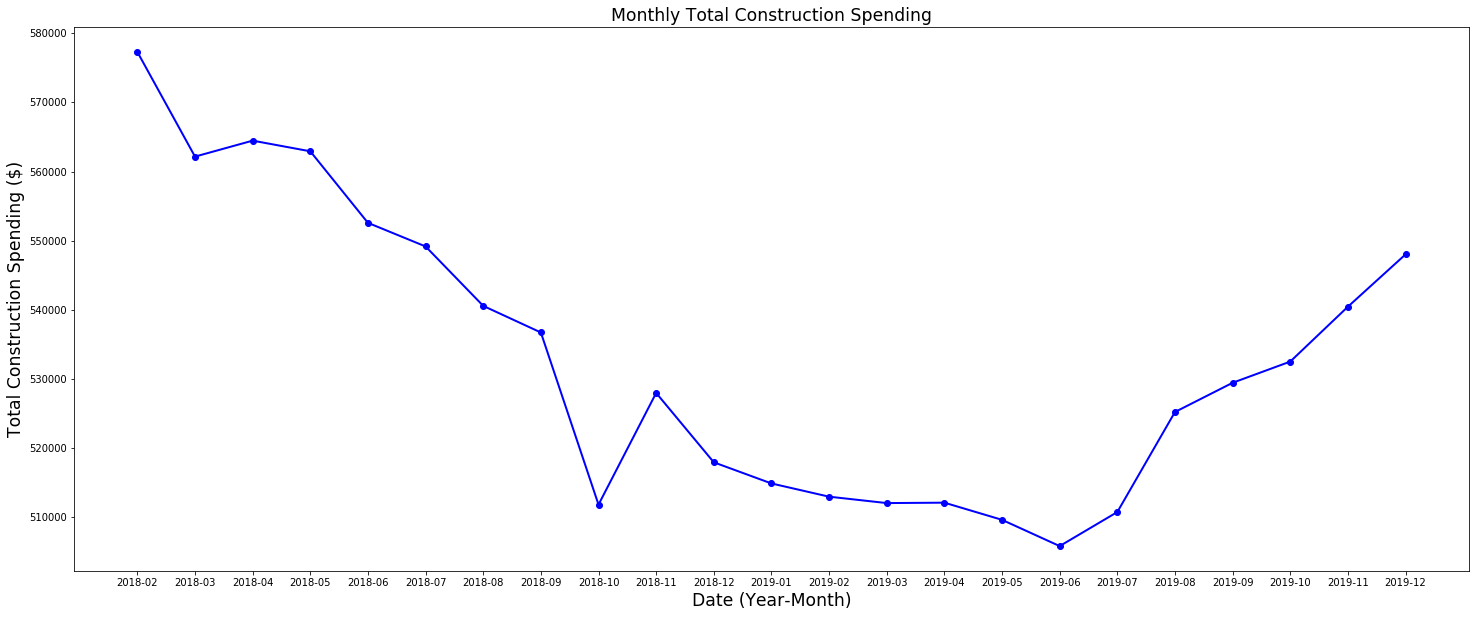

In [62]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig2 = plt.figure(figsize=(25,10))
plt.plot(months, COSP['data_value'], marker='o', color='b', linewidth=2)
plt.title('Monthly Total Construction Spending',fontsize='xx-large')
plt.ylabel('Total Construction Spending ($)',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

### CSTM

In [63]:
CSTM=FreightWaves[FreightWaves['ticker']=='CSTM']

In [64]:
set(CSTM['granularity1'])

{'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [65]:
CSTM_value=CSTM.groupby(['granularity1','data_timestamp']).mean()

In [66]:
CSTM_value = CSTM_value.reset_index()

In [67]:
cstm_chi=list(CSTM_value[CSTM_value['granularity1']=='CHI']['data_timestamp'])
cstm_dal=list(CSTM_value[CSTM_value['granularity1']=='DAL']['data_timestamp'])
cstm_lax=list(CSTM_value[CSTM_value['granularity1']=='LAX']['data_timestamp'])
cstm_phl=list(CSTM_value[CSTM_value['granularity1']=='PHL']['data_timestamp'])
cstm_sea=list(CSTM_value[CSTM_value['granularity1']=='SEA']['data_timestamp'])

In [68]:
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(cstm_chi)):
    x_chi.append(cstm_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(cstm_dal)):
    x_dal.append(cstm_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(cstm_lax)):
    x_lax.append(cstm_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(cstm_phl)):
    x_phl.append(cstm_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(cstm_sea)):
    x_sea.append(cstm_sea[i].strftime('%Y-%m-%d'))

In [69]:
y_chi=CSTM_value[CSTM_value['granularity1']=='CHI']['data_value']
y_dal=CSTM_value[CSTM_value['granularity1']=='DAL']['data_value']
y_lax=CSTM_value[CSTM_value['granularity1']=='LAX']['data_value']
y_phl=CSTM_value[CSTM_value['granularity1']=='PHL']['data_value']
y_sea=CSTM_value[CSTM_value['granularity1']=='SEA']['data_value']

Text(0.5, 0, 'Date (Year-Month-Day)')

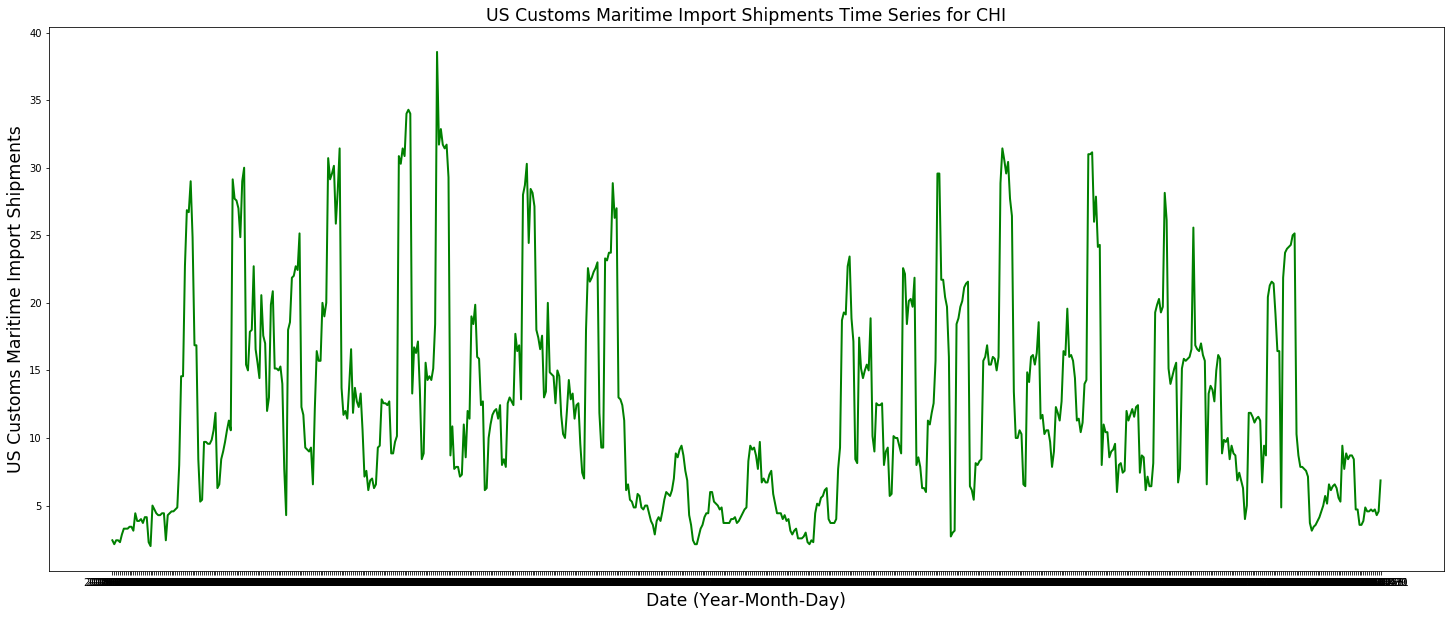

In [70]:
fig3 = plt.figure(figsize=(25,10))
plt.plot(x_chi, y_chi, marker='', color='g', linewidth=2,label="CHI")
plt.title('US Customs Maritime Import Shipments Time Series for CHI',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month-Day)')

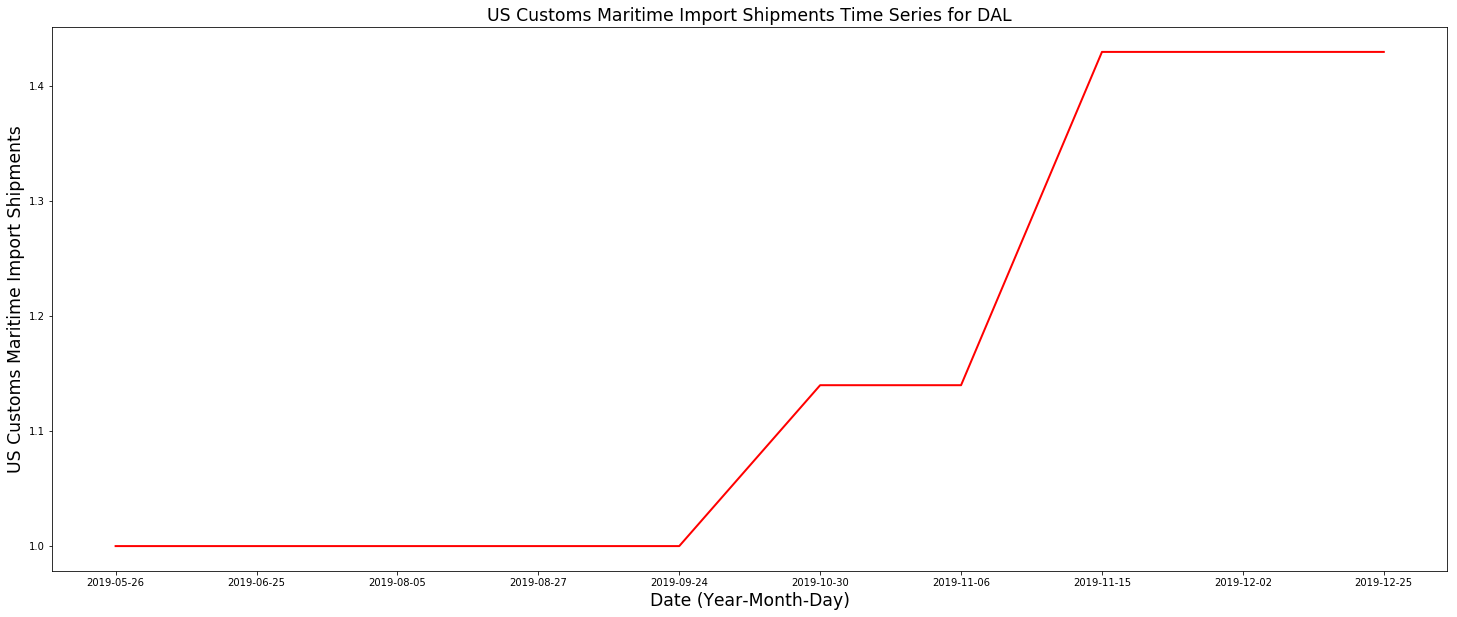

In [71]:
fig4 = plt.figure(figsize=(25,10))
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.title('US Customs Maritime Import Shipments Time Series for DAL',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month-Day)')

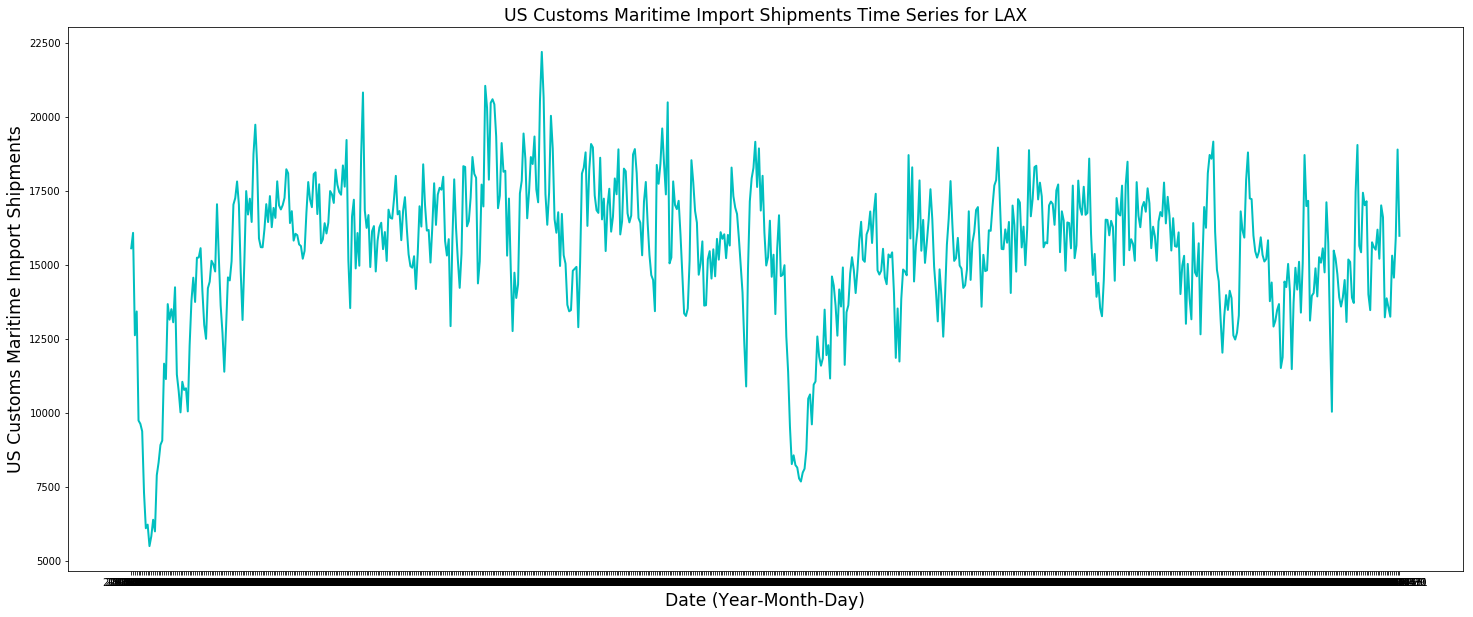

In [72]:
fig5 = plt.figure(figsize=(25,10))
plt.plot(x_lax, y_lax, marker='', color='c', linewidth=2,label="LAX")
plt.title('US Customs Maritime Import Shipments Time Series for LAX',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month-Day)')

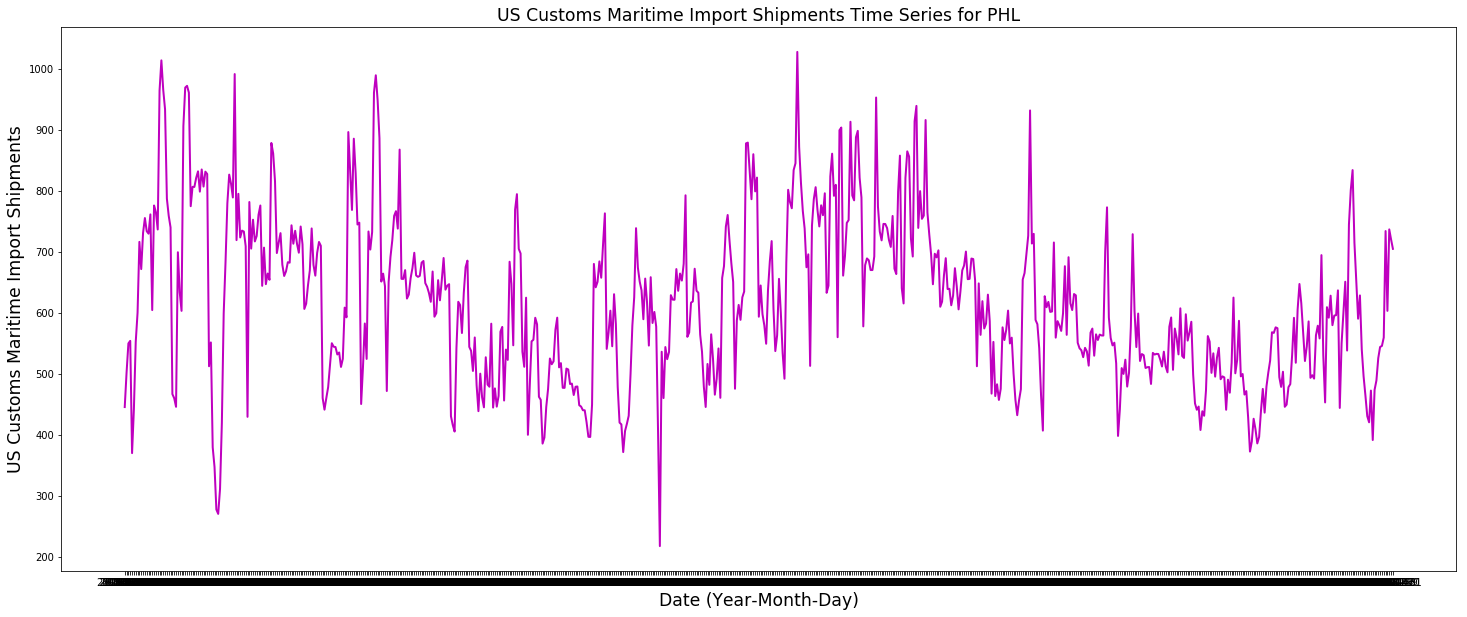

In [73]:
fig6 = plt.figure(figsize=(25,10))
plt.plot(x_phl, y_phl, marker='', color='m', linewidth=2,label="PHL")
plt.title('US Customs Maritime Import Shipments Time Series for PHL',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

Text(0.5, 0, 'Date (Year-Month-Day)')

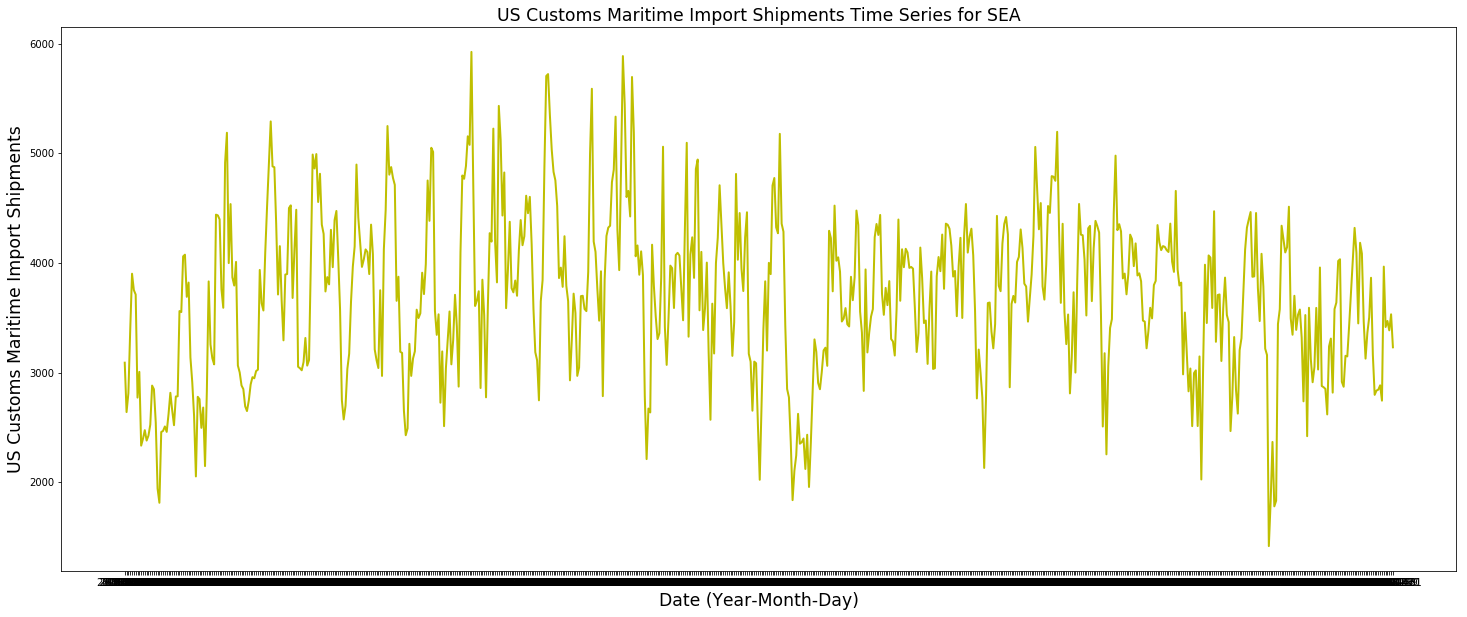

In [74]:
fig7 = plt.figure(figsize=(25,10))
plt.plot(x_sea, y_sea, marker='', color='y', linewidth=2,label="SEA")
plt.title('US Customs Maritime Import Shipments Time Series for SEA',fontsize='xx-large')
plt.ylabel('US Customs Maritime Import Shipments',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')

### DATVF

In [75]:
DATVF=FreightWaves[FreightWaves['ticker']=='DATVF']

In [76]:
set(DATVF['granularity1'])

{'ATLPHL', 'CHIATL', 'DALLAX', 'LAXDAL', 'LAXSEA', 'PHLCHI', 'SEALAX'}

In [77]:
#per = DATVF.data_timestamp.dt.to_period("D")

In [78]:
DATVF_value=DATVF.groupby(['granularity1','data_timestamp']).mean()

In [79]:
DATVF_value=DATVF_value.reset_index()

In [80]:
datvf_vap=list(DATVF_value[DATVF_value['granularity1']=='ATLPHL']['data_timestamp'])
datvf_vca=list(DATVF_value[DATVF_value['granularity1']=='CHIATL']['data_timestamp'])
datvf_vdl=list(DATVF_value[DATVF_value['granularity1']=='DALLAX']['data_timestamp'])
datvf_vld=list(DATVF_value[DATVF_value['granularity1']=='LAXDAL']['data_timestamp'])
datvf_vls=list(DATVF_value[DATVF_value['granularity1']=='LAXSEA']['data_timestamp'])
datvf_vpc=list(DATVF_value[DATVF_value['granularity1']=='PHLCHI']['data_timestamp'])
datvf_vsl=list(DATVF_value[DATVF_value['granularity1']=='SEALAX']['data_timestamp'])

In [81]:
x_vap=[]
x_vca=[]
x_vdl=[]
x_vld=[]
x_vls=[]
x_vpc=[]
x_vsl=[]

for i in range(len(datvf_vap)):
    x_vap.append(datvf_vap[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vca)):
    x_vca.append(datvf_vca[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vdl)):
    x_vdl.append(datvf_vdl[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vld)):
    x_vld.append(datvf_vld[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vls)):
    x_vls.append(datvf_vls[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vpc)):
    x_vpc.append(datvf_vpc[i].strftime('%Y-%m-%d'))
    
for i in range(len(datvf_vsl)):
    x_vsl.append(datvf_vsl[i].strftime('%Y-%m-%d'))

In [82]:
y_vap=DATVF_value[DATVF_value['granularity1']=='ATLPHL']['data_value']
y_vca=DATVF_value[DATVF_value['granularity1']=='CHIATL']['data_value']
y_vdl=DATVF_value[DATVF_value['granularity1']=='DALLAX']['data_value']
y_vld=DATVF_value[DATVF_value['granularity1']=='LAXDAL']['data_value']
y_vls=DATVF_value[DATVF_value['granularity1']=='LAXSEA']['data_value']
y_vpc=DATVF_value[DATVF_value['granularity1']=='PHLCHI']['data_value']
y_vsl=DATVF_value[DATVF_value['granularity1']=='SEALAX']['data_value']

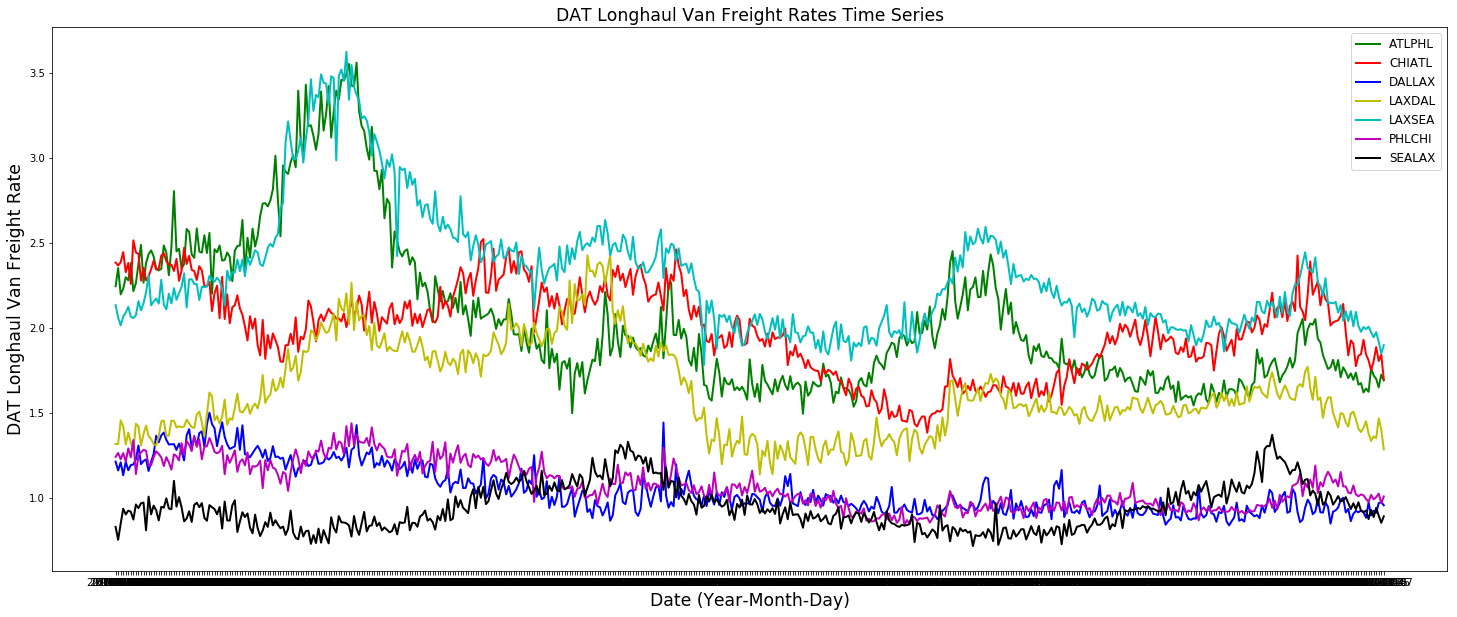

In [83]:
fig8 = plt.figure(figsize=(25,10))
plt.plot(x_vap, y_vap, marker='', color='g', linewidth=2,label="ATLPHL")
plt.plot(x_vca, y_vca, marker='', color='r', linewidth=2,label="CHIATL")
plt.plot(x_vdl, y_vdl, marker='', color='b', linewidth=2,label="DALLAX")
plt.plot(x_vld, y_vld, marker='', color='y', linewidth=2,label="LAXDAL")
plt.plot(x_vls, y_vls, marker='', color='c', linewidth=2,label="LAXSEA")
plt.plot(x_vpc, y_vpc, marker='', color='m', linewidth=2,label="PHLCHI")
plt.plot(x_vsl, y_vsl, marker='', color='k', linewidth=2,label="SEALAX")
plt.title('DAT Longhaul Van Freight Rates Time Series',fontsize='xx-large')
plt.ylabel('DAT Longhaul Van Freight Rate',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### DTS

In [84]:
DTS=FreightWaves[FreightWaves['ticker']=='DTS']

In [85]:
set(DTS['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [86]:
#per = DTS.data_timestamp.dt.to_period("D")

In [87]:
DTS_value=DTS.groupby(['granularity1','data_timestamp']).mean()

In [88]:
DTS_value=DTS_value.reset_index()

In [89]:
dts_atl=list(DTS_value[DTS_value['granularity1']=='ATL']['data_timestamp'])
dts_chi=list(DTS_value[DTS_value['granularity1']=='CHI']['data_timestamp'])
dts_dal=list(DTS_value[DTS_value['granularity1']=='DAL']['data_timestamp'])
dts_lax=list(DTS_value[DTS_value['granularity1']=='LAX']['data_timestamp'])
dts_phl=list(DTS_value[DTS_value['granularity1']=='PHL']['data_timestamp'])
dts_sea=list(DTS_value[DTS_value['granularity1']=='SEA']['data_timestamp'])

In [90]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(dts_atl)):
    x_atl.append(dts_atl[i].strftime('%Y-%m-%d'))

for i in range(len(dts_chi)):
    x_chi.append(dts_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(dts_dal)):
    x_dal.append(dts_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(dts_lax)):
    x_lax.append(dts_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(dts_phl)):
    x_phl.append(dts_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(dts_sea)):
    x_sea.append(dts_sea[i].strftime('%Y-%m-%d'))

In [91]:
y_atl=DTS_value[DTS_value['granularity1']=='ATL']['data_value']
y_chi=DTS_value[DTS_value['granularity1']=='CHI']['data_value']
y_dal=DTS_value[DTS_value['granularity1']=='DAL']['data_value']
y_lax=DTS_value[DTS_value['granularity1']=='LAX']['data_value']
y_phl=DTS_value[DTS_value['granularity1']=='PHL']['data_value']
y_sea=DTS_value[DTS_value['granularity1']=='SEA']['data_value']

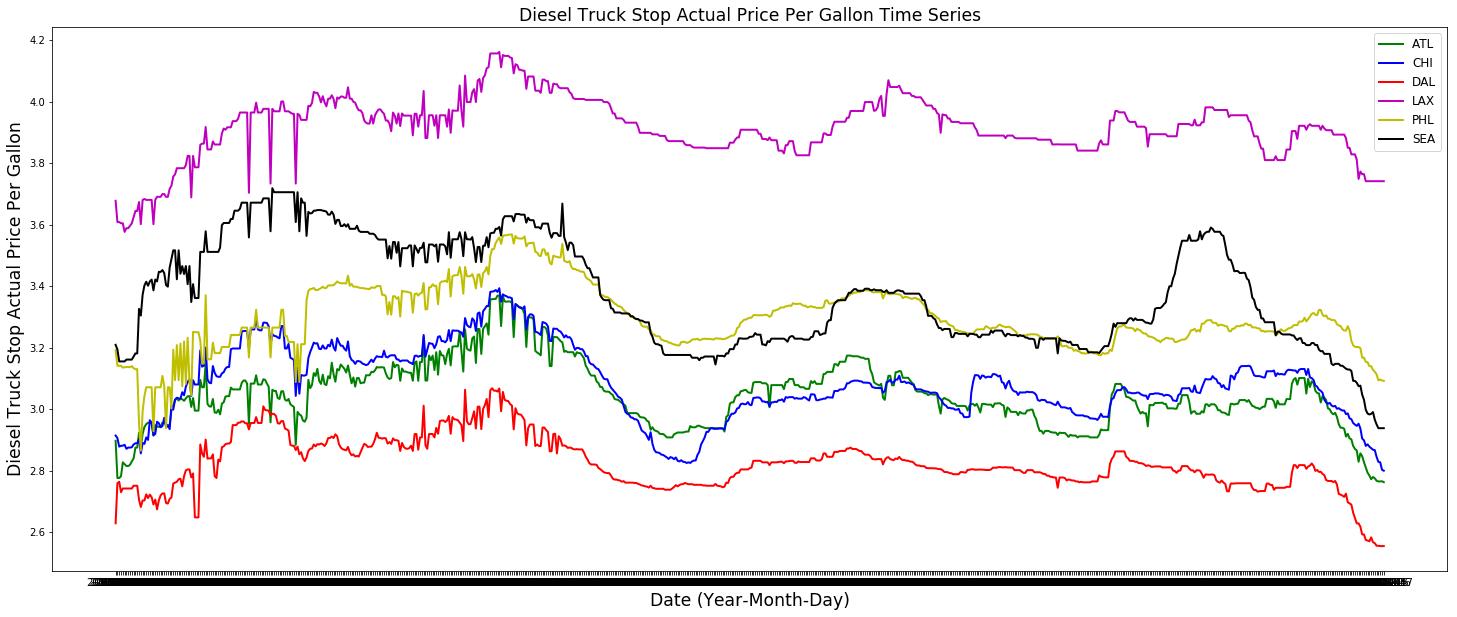

In [92]:
fig9 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Diesel Truck Stop Actual Price Per Gallon Time Series',fontsize='xx-large')
plt.ylabel('Diesel Truck Stop Actual Price Per Gallon',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### HAUL

In [93]:
HAUL=FreightWaves[FreightWaves['ticker']=='HAUL']

In [94]:
set(HAUL['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [95]:
#per = HAUL.data_timestamp.dt.to_period("D")

In [96]:
HAUL_value=HAUL.groupby(['granularity1','data_timestamp']).mean()

In [97]:
HAUL_value=HAUL_value.reset_index()

In [98]:
haul_atl=list(HAUL_value[HAUL_value['granularity1']=='ATL']['data_timestamp'])
haul_chi=list(HAUL_value[HAUL_value['granularity1']=='CHI']['data_timestamp'])
haul_dal=list(HAUL_value[HAUL_value['granularity1']=='DAL']['data_timestamp'])
haul_lax=list(HAUL_value[HAUL_value['granularity1']=='LAX']['data_timestamp'])
haul_phl=list(HAUL_value[HAUL_value['granularity1']=='PHL']['data_timestamp'])
haul_sea=list(HAUL_value[HAUL_value['granularity1']=='SEA']['data_timestamp'])

In [99]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(haul_atl)):
    x_atl.append(haul_atl[i].strftime('%Y-%m-%d'))

for i in range(len(haul_chi)):
    x_chi.append(haul_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(haul_dal)):
    x_dal.append(haul_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(haul_lax)):
    x_lax.append(haul_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(haul_phl)):
    x_phl.append(haul_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(haul_sea)):
    x_sea.append(haul_sea[i].strftime('%Y-%m-%d'))

In [100]:
y_atl=HAUL_value[HAUL_value['granularity1']=='ATL']['data_value']
y_chi=HAUL_value[HAUL_value['granularity1']=='CHI']['data_value']
y_dal=HAUL_value[HAUL_value['granularity1']=='DAL']['data_value']
y_lax=HAUL_value[HAUL_value['granularity1']=='LAX']['data_value']
y_phl=HAUL_value[HAUL_value['granularity1']=='PHL']['data_value']
y_sea=HAUL_value[HAUL_value['granularity1']=='SEA']['data_value']

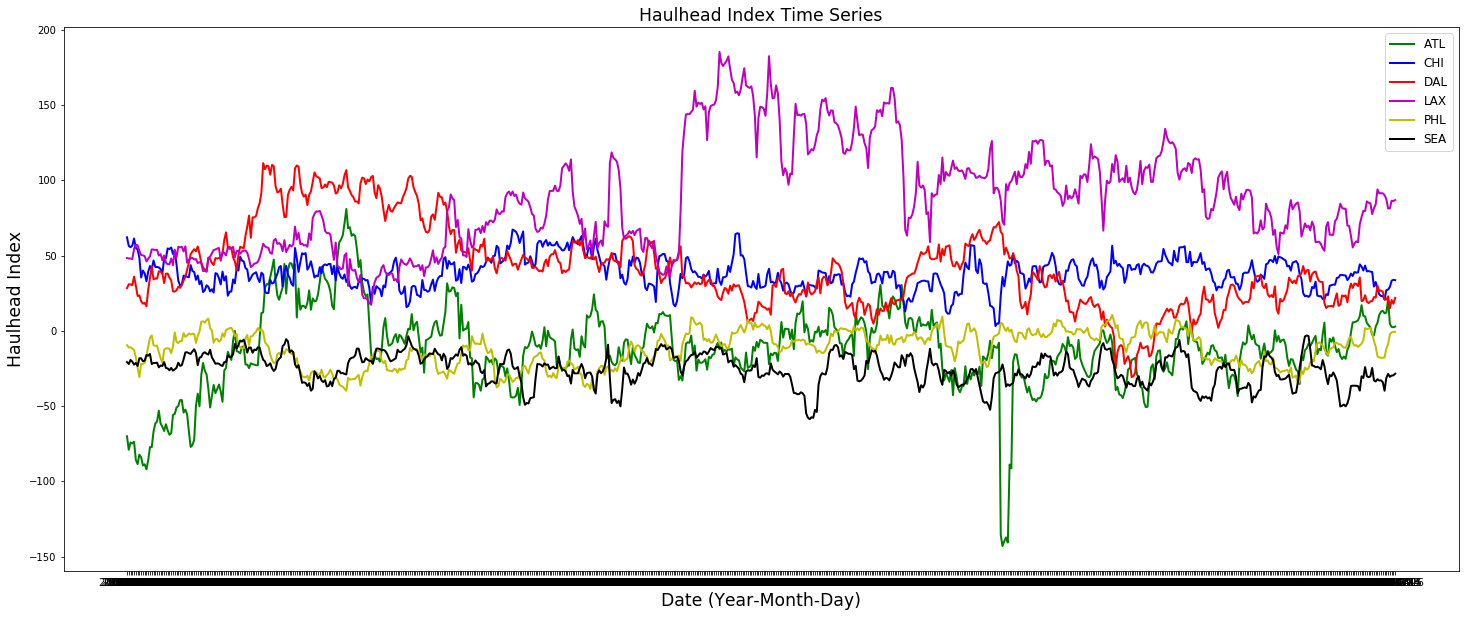

In [101]:
fig10 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Haulhead Index Time Series',fontsize='xx-large')
plt.ylabel('Haulhead Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### INTRM

In [102]:
INTRM=FreightWaves[FreightWaves['ticker']=='INTRM']

In [103]:
set(INTRM['granularity1'])

{'ATLLIN', 'CHIATL', 'DALLAX', 'LAXDAL', 'LAXSEA', 'LINCHI', 'SEALAX'}

In [104]:
#per = INTRM.data_timestamp.dt.to_period("D")

In [105]:
INTRM_value=INTRM.groupby(['granularity1','data_timestamp']).mean()

In [106]:
INTRM_value=INTRM_value.reset_index()

In [107]:
intrm_van=list(INTRM_value[INTRM_value['granularity1']=='ATLLIN']['data_timestamp'])
intrm_vca=list(INTRM_value[INTRM_value['granularity1']=='CHIATL']['data_timestamp'])
intrm_vdl=list(INTRM_value[INTRM_value['granularity1']=='DALLAX']['data_timestamp'])
intrm_vld=list(INTRM_value[INTRM_value['granularity1']=='LAXDAL']['data_timestamp'])
intrm_vls=list(INTRM_value[INTRM_value['granularity1']=='LAXSEA']['data_timestamp'])
intrm_vnc=list(INTRM_value[INTRM_value['granularity1']=='LINCHI']['data_timestamp'])
intrm_vsl=list(INTRM_value[INTRM_value['granularity1']=='SEALAX']['data_timestamp'])

In [108]:
x_van=[]
x_vca=[]
x_vdl=[]
x_vld=[]
x_vls=[]
x_vnc=[]
x_vsl=[]

for i in range(len(intrm_van)):
    x_van.append(intrm_van[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vca)):
    x_vca.append(intrm_vca[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vdl)):
    x_vdl.append(intrm_vdl[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vld)):
    x_vld.append(intrm_vld[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vls)):
    x_vls.append(intrm_vls[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vnc)):
    x_vnc.append(intrm_vnc[i].strftime('%Y-%m-%d'))
    
for i in range(len(intrm_vsl)):
    x_vsl.append(intrm_vsl[i].strftime('%Y-%m-%d'))

In [109]:
y_van=INTRM_value[INTRM_value['granularity1']=='ATLLIN']['data_value']
y_vca=INTRM_value[INTRM_value['granularity1']=='CHIATL']['data_value']
y_vdl=INTRM_value[INTRM_value['granularity1']=='DALLAX']['data_value']
y_vld=INTRM_value[INTRM_value['granularity1']=='LAXDAL']['data_value']
y_vls=INTRM_value[INTRM_value['granularity1']=='LAXSEA']['data_value']
y_vnc=INTRM_value[INTRM_value['granularity1']=='LINCHI']['data_value']
y_vsl=INTRM_value[INTRM_value['granularity1']=='SEALAX']['data_value']

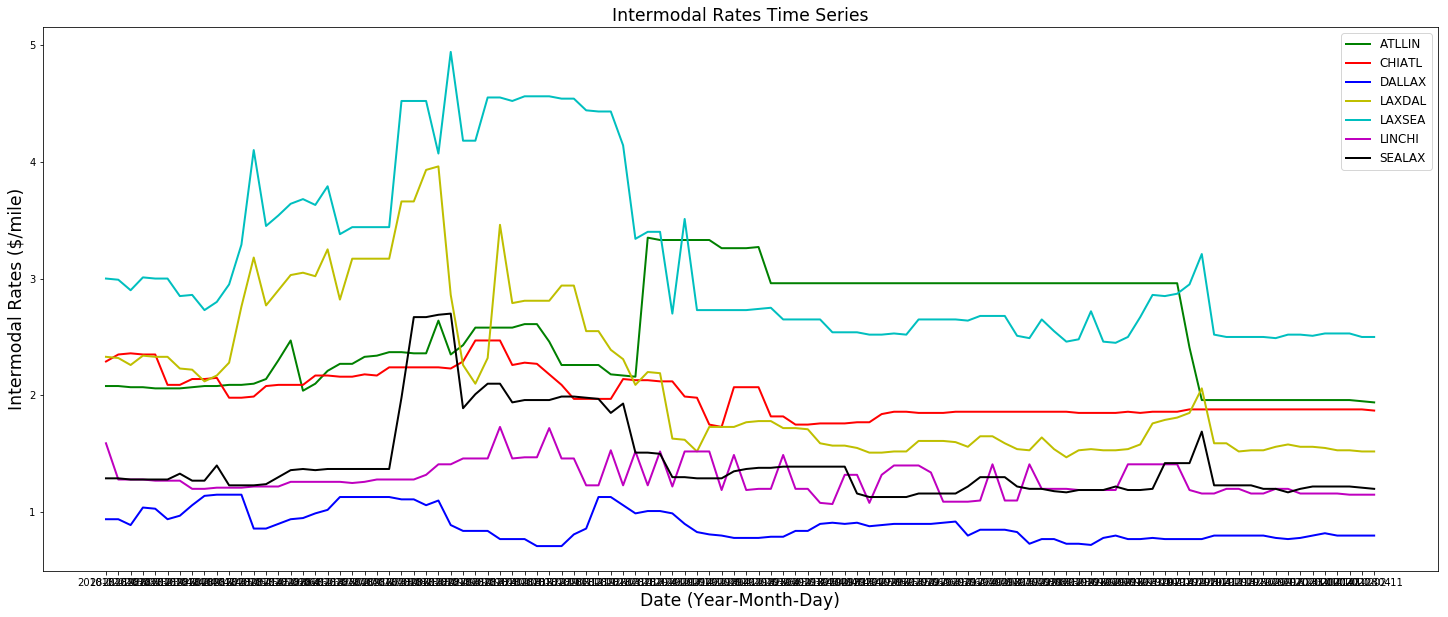

In [110]:
fig11 = plt.figure(figsize=(25,10))
plt.plot(x_van, y_van, marker='', color='g', linewidth=2,label="ATLLIN")
plt.plot(x_vca, y_vca, marker='', color='r', linewidth=2,label="CHIATL")
plt.plot(x_vdl, y_vdl, marker='', color='b', linewidth=2,label="DALLAX")
plt.plot(x_vld, y_vld, marker='', color='y', linewidth=2,label="LAXDAL")
plt.plot(x_vls, y_vls, marker='', color='c', linewidth=2,label="LAXSEA")
plt.plot(x_vnc, y_vnc, marker='', color='m', linewidth=2,label="LINCHI")
plt.plot(x_vsl, y_vsl, marker='', color='k', linewidth=2,label="SEALAX")
plt.title('Intermodal Rates Time Series',fontsize='xx-large')
plt.ylabel('Intermodal Rates ($/mile)',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### IPRO

In [111]:
IPRO=FreightWaves[FreightWaves['ticker']=='IPRO']

In [112]:
set(IPRO['granularity1'])

{'FBEVT', 'USA'}

In [113]:
IPRO_FBEVT=IPRO[IPRO['granularity1']=='FBEVT']

In [114]:
IPRO_FBEVT=IPRO_FBEVT.sort_values(by='data_timestamp').reset_index(drop=True)

In [115]:
IPRO_USA=IPRO[IPRO['granularity1']=='USA']

In [116]:
IPRO_USA=IPRO_USA.sort_values(by='data_timestamp').reset_index(drop=True)

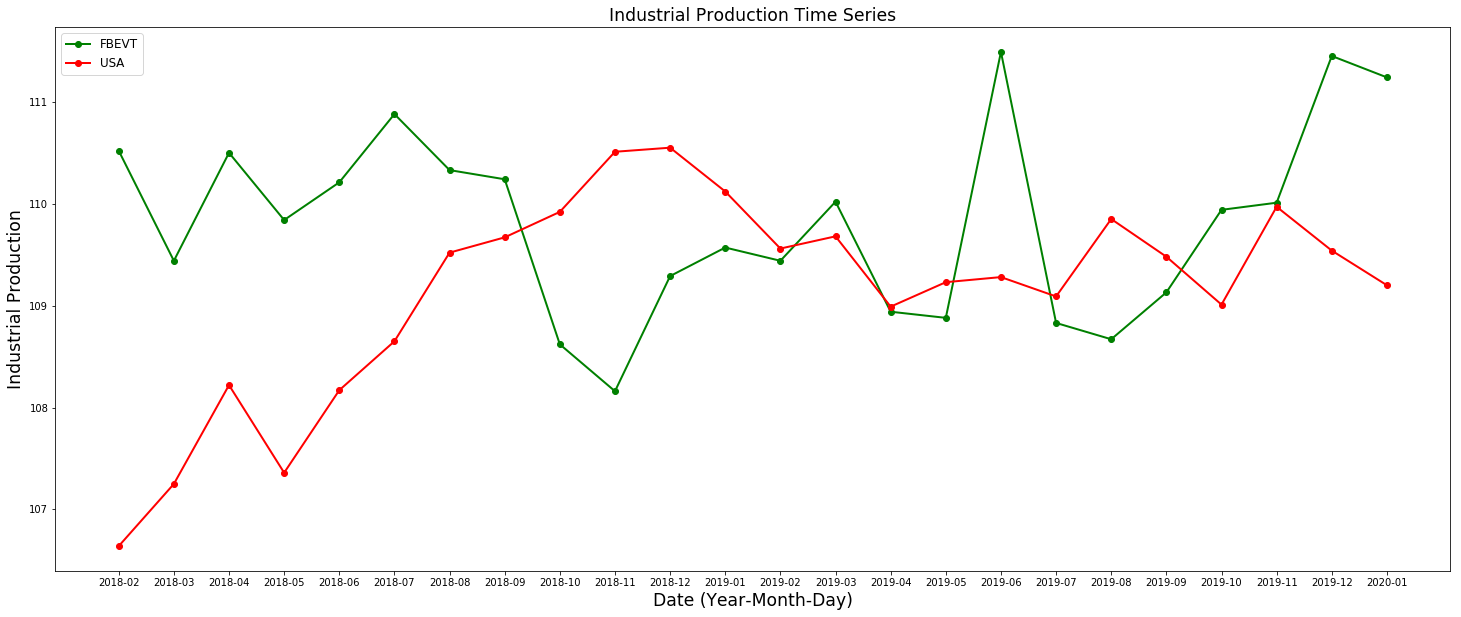

In [117]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']

fig12 = plt.figure(figsize=(25,10))
plt.plot(months, IPRO_FBEVT['data_value'], marker='o', color='g', linewidth=2,label="FBEVT")
plt.plot(months, IPRO_USA['data_value'], marker='o', color='r', linewidth=2,label="USA")
plt.title('Industrial Production Time Series',fontsize='xx-large')
plt.ylabel('Industrial Production',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### ISM

In [118]:
ISM=FreightWaves[FreightWaves['ticker']=='ISM']

In [119]:
ISM=ISM.sort_values(by='data_timestamp').reset_index(drop=True)

Text(0.5, 0, 'Date (Year-Month)')

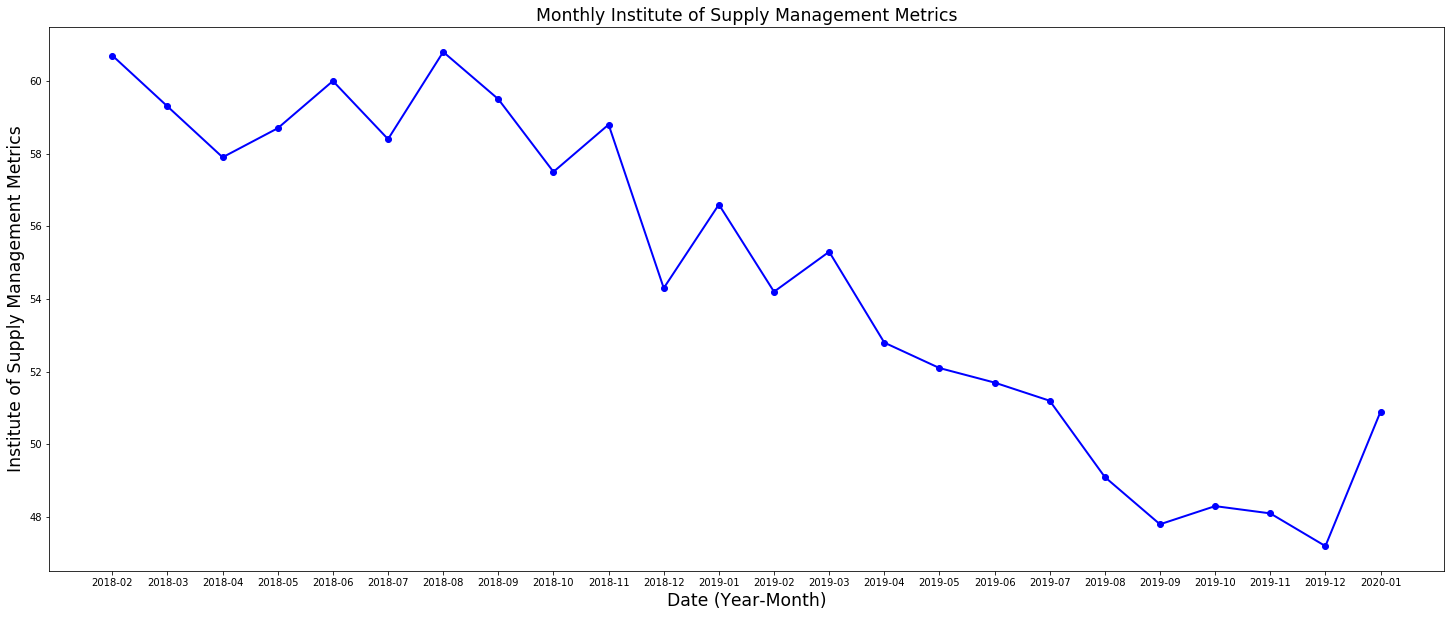

In [120]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']

fig13 = plt.figure(figsize=(25,10))
plt.plot(months, ISM['data_value'], marker='o', color='b', linewidth=2)
plt.title('Monthly Institute of Supply Management Metrics',fontsize='xx-large')
plt.ylabel('Institute of Supply Management Metrics',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

### ORAIL53L

In [121]:
ORAIL53L=FreightWaves[FreightWaves['ticker']=='ORAIL53L']

In [122]:
set(ORAIL53L['granularity1'])

{'ATLPHL', 'CHIATL', 'DALLAX', 'LAXDAL', 'LAXSEA', 'PHLCHI', 'SEALAX'}

In [123]:
#per = ORAIL53L.data_timestamp.dt.to_period("D")

In [124]:
ORAIL53L_value=ORAIL53L.groupby(['granularity1','data_timestamp']).mean()

In [125]:
ORAIL53L_value=ORAIL53L_value.reset_index()

In [126]:
orail53l_vap=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='ATLPHL']['data_timestamp'])
orail53l_vca=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='CHIATL']['data_timestamp'])
orail53l_vdl=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='DALLAX']['data_timestamp'])
orail53l_vld=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='LAXDAL']['data_timestamp'])
orail53l_vls=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='LAXSEA']['data_timestamp'])
orail53l_vpc=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='PHLCHI']['data_timestamp'])
orail53l_vsl=list(ORAIL53L_value[ORAIL53L_value['granularity1']=='SEALAX']['data_timestamp'])

In [127]:
x_vap=[]
x_vca=[]
x_vdl=[]
x_vld=[]
x_vls=[]
x_vpc=[]
x_vsl=[]

for i in range(len(orail53l_vap)):
    x_vap.append(orail53l_vap[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vca)):
    x_vca.append(orail53l_vca[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vdl)):
    x_vdl.append(orail53l_vdl[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vld)):
    x_vld.append(orail53l_vld[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vls)):
    x_vls.append(orail53l_vls[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vpc)):
    x_vpc.append(orail53l_vpc[i].strftime('%Y-%m-%d'))
    
for i in range(len(orail53l_vsl)):
    x_vsl.append(orail53l_vsl[i].strftime('%Y-%m-%d'))

In [128]:
y_vap=ORAIL53L_value[ORAIL53L_value['granularity1']=='ATLPHL']['data_value']
y_vca=ORAIL53L_value[ORAIL53L_value['granularity1']=='CHIATL']['data_value']
y_vdl=ORAIL53L_value[ORAIL53L_value['granularity1']=='DALLAX']['data_value']
y_vld=ORAIL53L_value[ORAIL53L_value['granularity1']=='LAXDAL']['data_value']
y_vls=ORAIL53L_value[ORAIL53L_value['granularity1']=='LAXSEA']['data_value']
y_vpc=ORAIL53L_value[ORAIL53L_value['granularity1']=='PHLCHI']['data_value']
y_vsl=ORAIL53L_value[ORAIL53L_value['granularity1']=='SEALAX']['data_value']

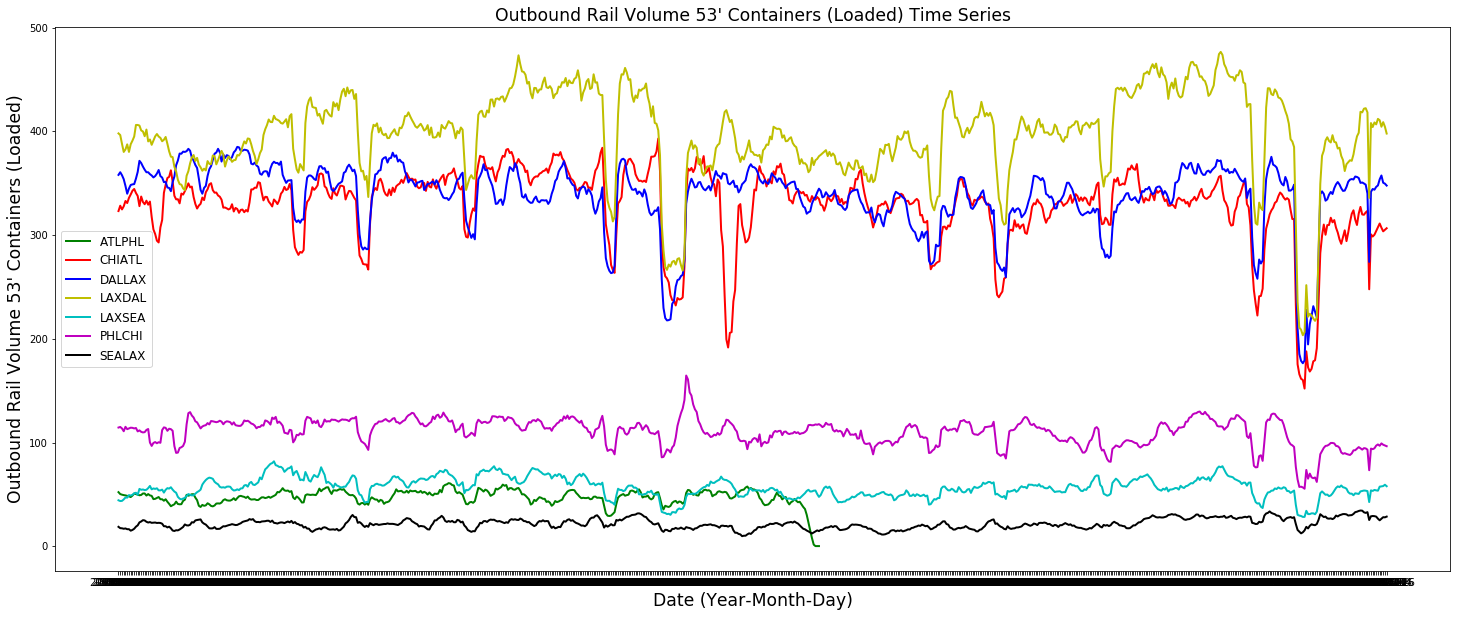

In [129]:
fig14 = plt.figure(figsize=(25,10))
plt.plot(x_vap, y_vap, marker='', color='g', linewidth=2,label="ATLPHL")
plt.plot(x_vca, y_vca, marker='', color='r', linewidth=2,label="CHIATL")
plt.plot(x_vdl, y_vdl, marker='', color='b', linewidth=2,label="DALLAX")
plt.plot(x_vld, y_vld, marker='', color='y', linewidth=2,label="LAXDAL")
plt.plot(x_vls, y_vls, marker='', color='c', linewidth=2,label="LAXSEA")
plt.plot(x_vpc, y_vpc, marker='', color='m', linewidth=2,label="PHLCHI")
plt.plot(x_vsl, y_vsl, marker='', color='k', linewidth=2,label="SEALAX")
plt.title("Outbound Rail Volume 53' Containers (Loaded) Time Series",fontsize='xx-large')
plt.ylabel("Outbound Rail Volume 53' Containers (Loaded)",fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### ORDERS

In [130]:
ORDERS=FreightWaves[FreightWaves['ticker']=='ORDERS']

In [131]:
ORDERS=ORDERS.sort_values(by='data_timestamp').reset_index(drop=True)

Text(0.5, 0, 'Date (Year-Month)')

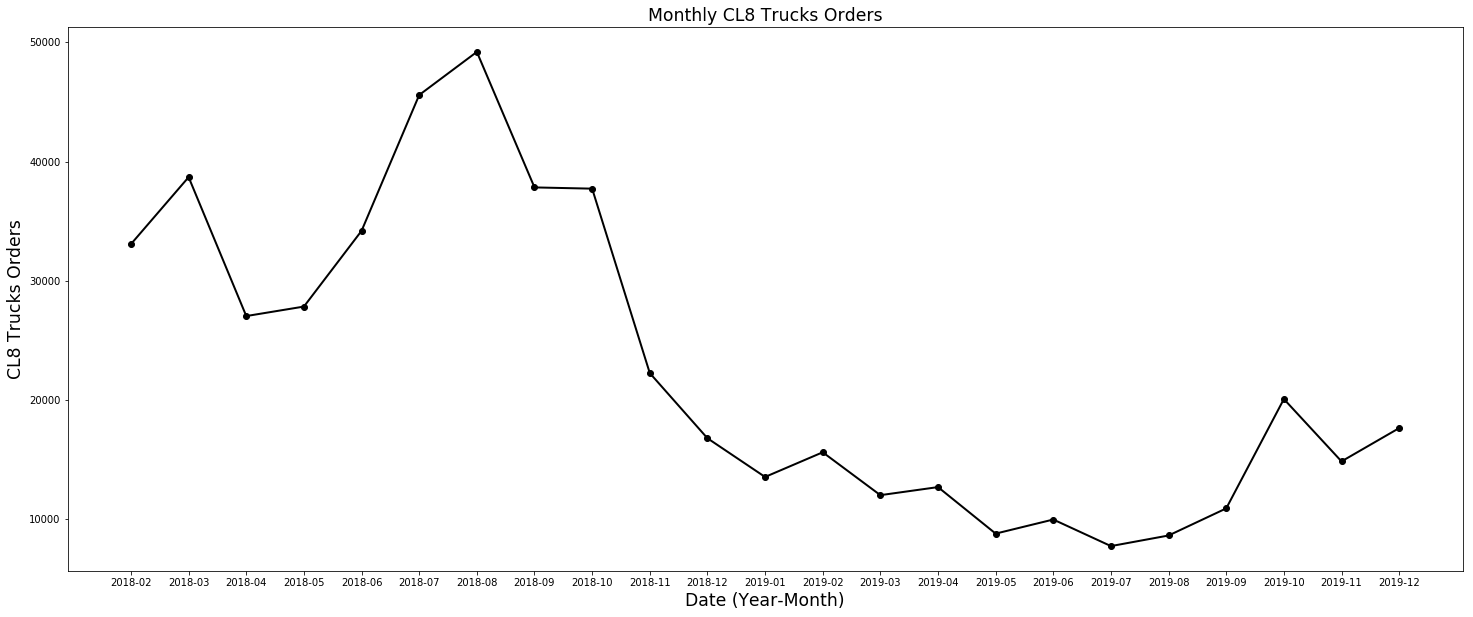

In [132]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig15 = plt.figure(figsize=(25,10))
plt.plot(months, ORDERS['data_value'], marker='o', color='k', linewidth=2)
plt.title('Monthly CL8 Trucks Orders',fontsize='xx-large')
plt.ylabel('CL8 Trucks Orders',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

### OTRI

In [133]:
OTRI=FreightWaves[FreightWaves['ticker']=='OTRI']

In [134]:
set(OTRI['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [135]:
#per = OTRI.data_timestamp.dt.to_period("D")

In [136]:
OTRI_value=OTRI.groupby(['granularity1','data_timestamp']).mean()

In [137]:
OTRI_value=OTRI_value.reset_index()

In [138]:
otri_atl=list(OTRI_value[OTRI_value['granularity1']=='ATL']['data_timestamp'])
otri_chi=list(OTRI_value[OTRI_value['granularity1']=='CHI']['data_timestamp'])
otri_dal=list(OTRI_value[OTRI_value['granularity1']=='DAL']['data_timestamp'])
otri_lax=list(OTRI_value[OTRI_value['granularity1']=='LAX']['data_timestamp'])
otri_phl=list(OTRI_value[OTRI_value['granularity1']=='PHL']['data_timestamp'])
otri_sea=list(OTRI_value[OTRI_value['granularity1']=='SEA']['data_timestamp'])

In [139]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(otri_atl)):
    x_atl.append(otri_atl[i].strftime('%Y-%m-%d'))

for i in range(len(otri_chi)):
    x_chi.append(otri_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(otri_dal)):
    x_dal.append(otri_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(otri_lax)):
    x_lax.append(otri_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(otri_phl)):
    x_phl.append(otri_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(otri_sea)):
    x_sea.append(otri_sea[i].strftime('%Y-%m-%d'))

In [140]:
y_atl=OTRI_value[OTRI_value['granularity1']=='ATL']['data_value']
y_chi=OTRI_value[OTRI_value['granularity1']=='CHI']['data_value']
y_dal=OTRI_value[OTRI_value['granularity1']=='DAL']['data_value']
y_lax=OTRI_value[OTRI_value['granularity1']=='LAX']['data_value']
y_phl=OTRI_value[OTRI_value['granularity1']=='PHL']['data_value']
y_sea=OTRI_value[OTRI_value['granularity1']=='SEA']['data_value']

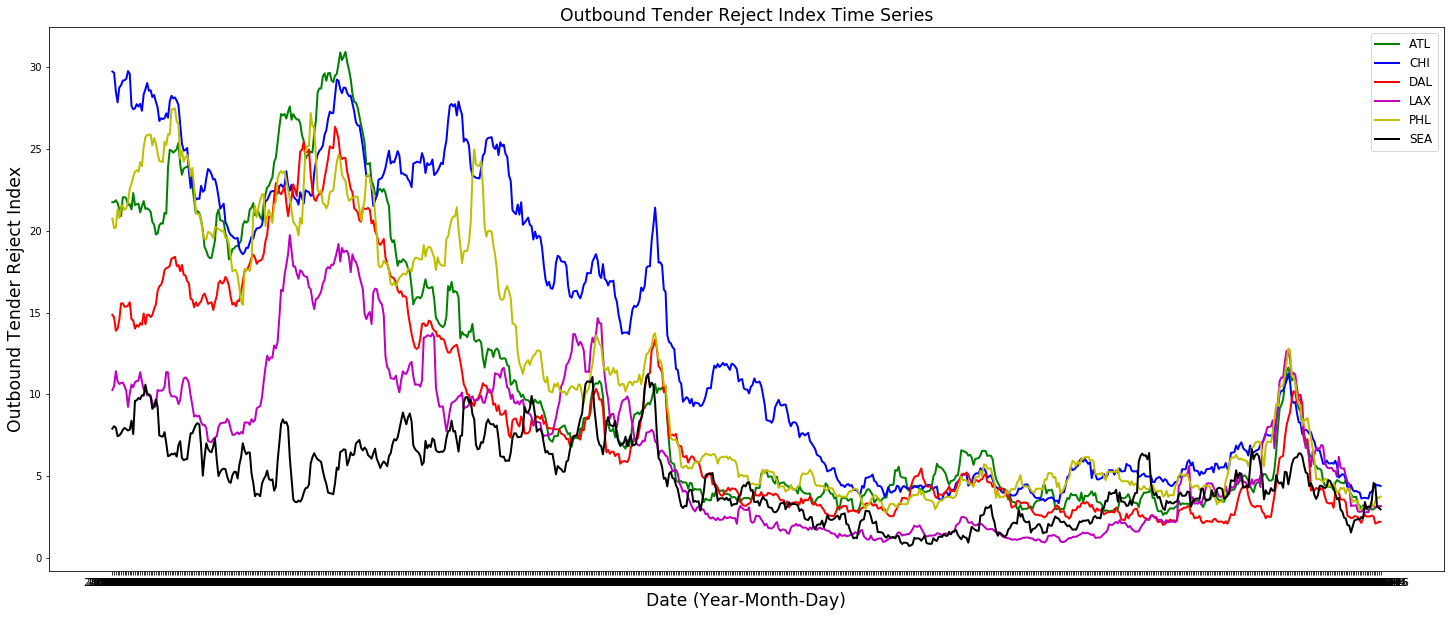

In [141]:
fig16 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Outbound Tender Reject Index Time Series',fontsize='xx-large')
plt.ylabel('Outbound Tender Reject Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### OTVI

In [142]:
OTVI=FreightWaves[FreightWaves['ticker']=='OTVI']

In [143]:
set(OTVI['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [144]:
#per = OTVI.data_timestamp.dt.to_period("D")

In [145]:
OTVI_value=OTVI.groupby(['granularity1','data_timestamp']).mean()

In [146]:
OTVI_value=OTVI_value.reset_index()

In [147]:
otvi_atl=list(OTVI_value[OTVI_value['granularity1']=='ATL']['data_timestamp'])
otvi_chi=list(OTVI_value[OTVI_value['granularity1']=='CHI']['data_timestamp'])
otvi_dal=list(OTVI_value[OTVI_value['granularity1']=='DAL']['data_timestamp'])
otvi_lax=list(OTVI_value[OTVI_value['granularity1']=='LAX']['data_timestamp'])
otvi_phl=list(OTVI_value[OTVI_value['granularity1']=='PHL']['data_timestamp'])
otvi_sea=list(OTVI_value[OTVI_value['granularity1']=='SEA']['data_timestamp'])

In [148]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(otvi_atl)):
    x_atl.append(otvi_atl[i].strftime('%Y-%m-%d'))

for i in range(len(otvi_chi)):
    x_chi.append(otvi_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(otvi_dal)):
    x_dal.append(otvi_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(otvi_lax)):
    x_lax.append(otvi_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(otvi_phl)):
    x_phl.append(otvi_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(otvi_sea)):
    x_sea.append(otvi_sea[i].strftime('%Y-%m-%d'))

In [149]:
y_atl=OTVI_value[OTVI_value['granularity1']=='ATL']['data_value']
y_chi=OTVI_value[OTVI_value['granularity1']=='CHI']['data_value']
y_dal=OTVI_value[OTVI_value['granularity1']=='DAL']['data_value']
y_lax=OTVI_value[OTVI_value['granularity1']=='LAX']['data_value']
y_phl=OTVI_value[OTVI_value['granularity1']=='PHL']['data_value']
y_sea=OTVI_value[OTVI_value['granularity1']=='SEA']['data_value']

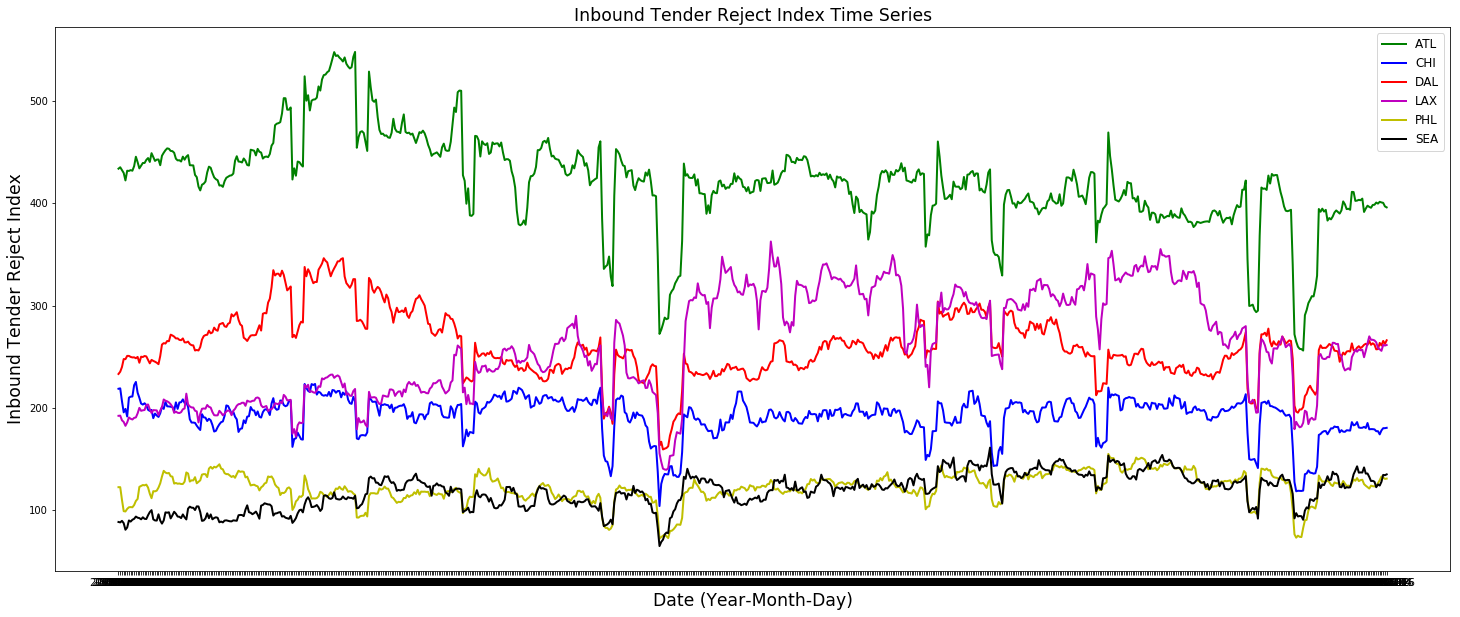

In [150]:
fig17 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Inbound Tender Reject Index Time Series',fontsize='xx-large')
plt.ylabel('Inbound Tender Reject Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### PPI

In [151]:
PPI=FreightWaves[FreightWaves['ticker']=='PPI']

In [152]:
PPI=PPI.sort_values(by='data_timestamp').reset_index(drop=True)

Text(0.5, 0, 'Date (Year-Month)')

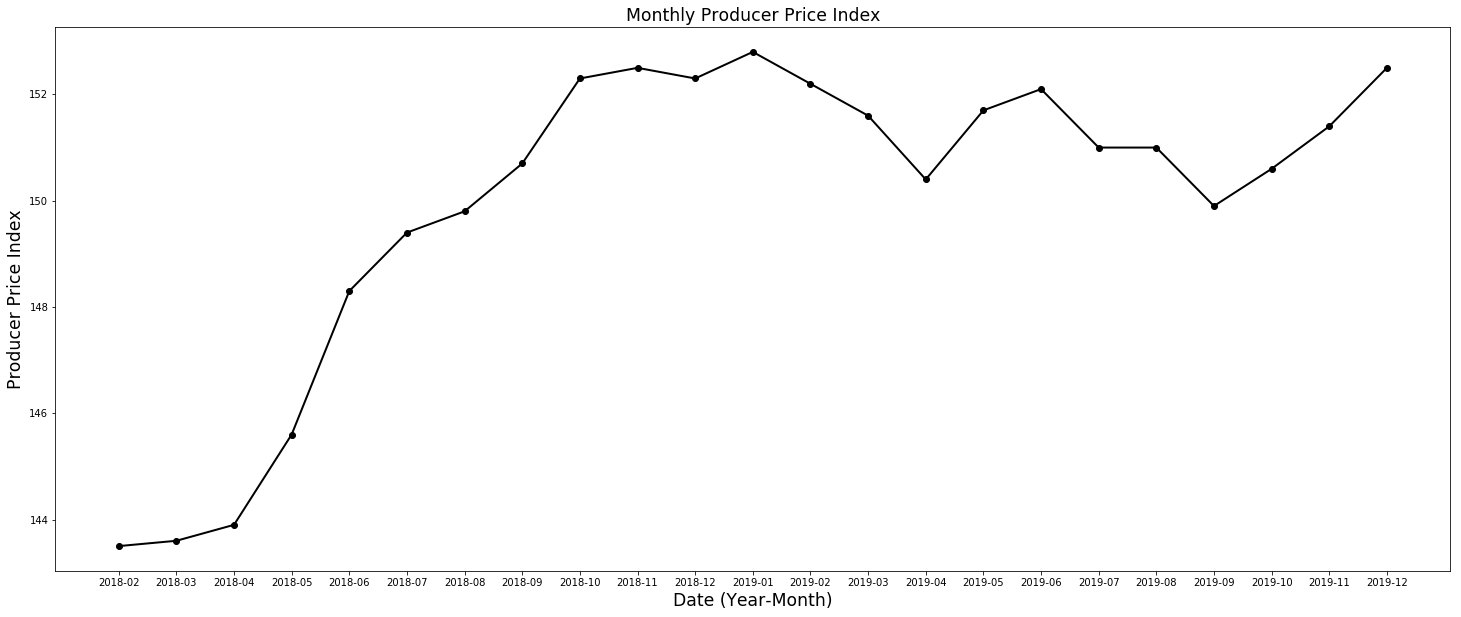

In [153]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig18 = plt.figure(figsize=(25,10))
plt.plot(months, PPI['data_value'], marker='o', color='k', linewidth=2)
plt.title('Monthly Producer Price Index',fontsize='xx-large')
plt.ylabel('Producer Price Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

### RESLG

In [154]:
RESLG=FreightWaves[FreightWaves['ticker']=='RESLG']

In [155]:
RESLG=RESLG.sort_values(by='data_timestamp').reset_index(drop=True)

Text(0.5, 0, 'Date (Year-Month)')

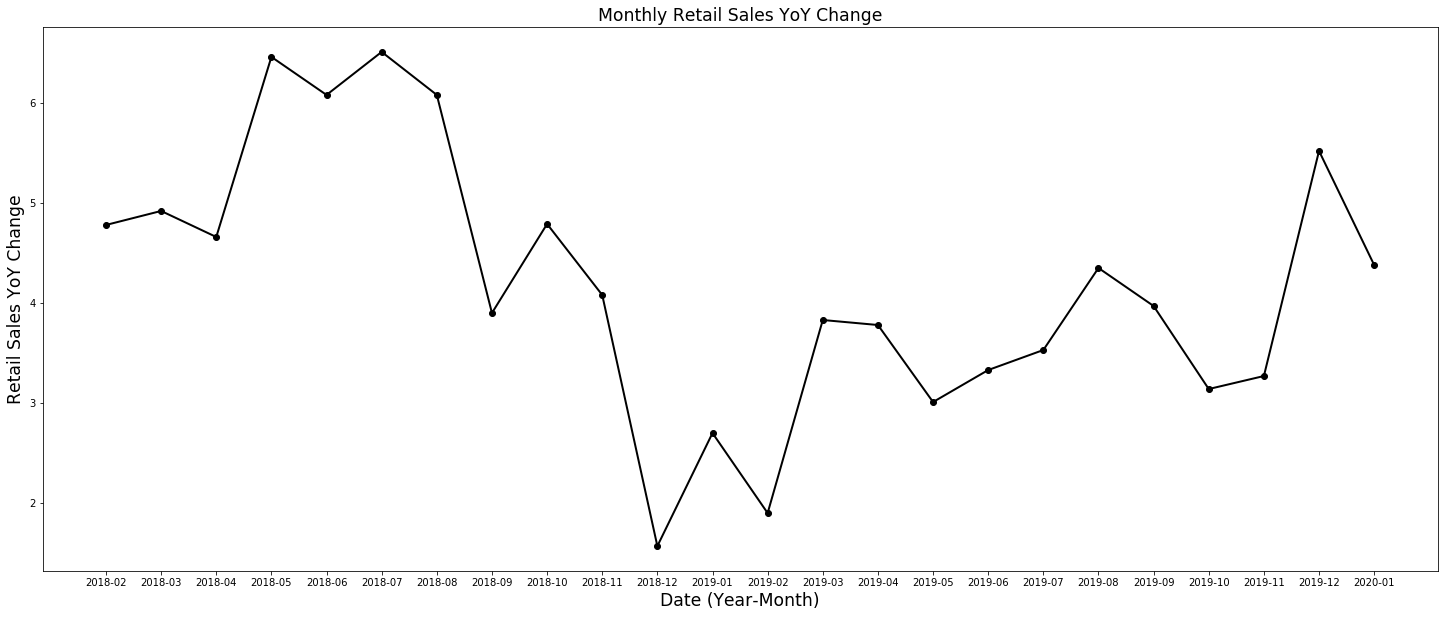

In [156]:
months=['2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']

fig19 = plt.figure(figsize=(25,10))
plt.plot(months, RESLG['data_value'], marker='o', color='k', linewidth=2)
plt.title('Monthly Retail Sales YoY Change',fontsize='xx-large')
plt.ylabel('Retail Sales YoY Change',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')

### TLT

In [157]:
TLT=FreightWaves[FreightWaves['ticker']=='TLT']

In [158]:
set(TLT['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [159]:
#per = TLT.data_timestamp.dt.to_period("D")

In [160]:
TLT_value=TLT.groupby(['granularity1','data_timestamp']).mean()

In [161]:
TLT_value=TLT_value.reset_index()

In [162]:
tlt_atl=list(TLT_value[TLT_value['granularity1']=='ATL']['data_timestamp'])
tlt_chi=list(TLT_value[TLT_value['granularity1']=='CHI']['data_timestamp'])
tlt_dal=list(TLT_value[TLT_value['granularity1']=='DAL']['data_timestamp'])
tlt_lax=list(TLT_value[TLT_value['granularity1']=='LAX']['data_timestamp'])
tlt_phl=list(TLT_value[TLT_value['granularity1']=='PHL']['data_timestamp'])
tlt_sea=list(TLT_value[TLT_value['granularity1']=='SEA']['data_timestamp'])

In [163]:
x_atl=[]
x_chi=[]
x_dal=[]
x_lax=[]
x_phl=[]
x_sea=[]

for i in range(len(tlt_atl)):
    x_atl.append(tlt_atl[i].strftime('%Y-%m-%d'))

for i in range(len(tlt_chi)):
    x_chi.append(tlt_chi[i].strftime('%Y-%m-%d'))
    
for i in range(len(tlt_dal)):
    x_dal.append(tlt_dal[i].strftime('%Y-%m-%d'))
    
for i in range(len(tlt_lax)):
    x_lax.append(tlt_lax[i].strftime('%Y-%m-%d'))
    
for i in range(len(tlt_phl)):
    x_phl.append(tlt_phl[i].strftime('%Y-%m-%d'))
    
for i in range(len(tlt_sea)):
    x_sea.append(tlt_sea[i].strftime('%Y-%m-%d'))

In [164]:
y_atl=TLT_value[TLT_value['granularity1']=='ATL']['data_value']
y_chi=TLT_value[TLT_value['granularity1']=='CHI']['data_value']
y_dal=TLT_value[TLT_value['granularity1']=='DAL']['data_value']
y_lax=TLT_value[TLT_value['granularity1']=='LAX']['data_value']
y_phl=TLT_value[TLT_value['granularity1']=='PHL']['data_value']
y_sea=TLT_value[TLT_value['granularity1']=='SEA']['data_value']

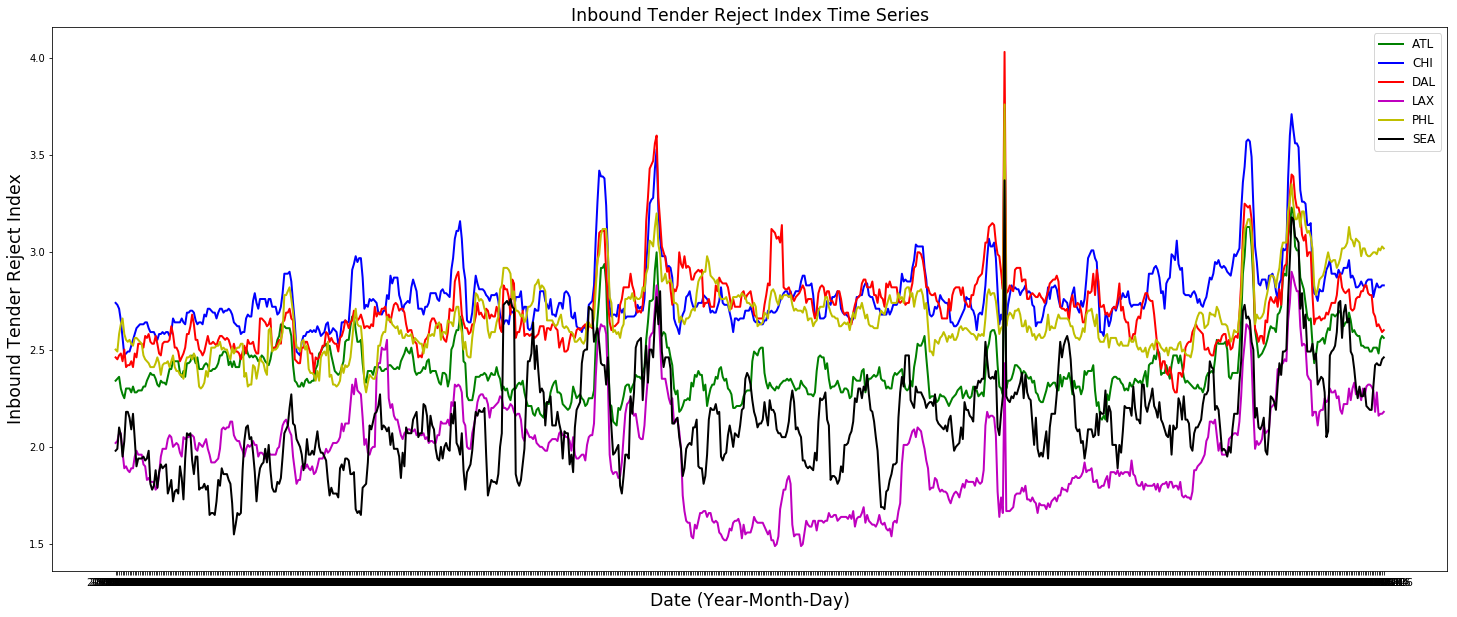

In [165]:
fig20 = plt.figure(figsize=(25,10))
plt.plot(x_atl, y_atl, marker='', color='g', linewidth=2,label="ATL")
plt.plot(x_chi, y_chi, marker='', color='b', linewidth=2,label="CHI")
plt.plot(x_dal, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot(x_lax, y_lax, marker='', color='m', linewidth=2,label="LAX")
plt.plot(x_phl, y_phl, marker='', color='y', linewidth=2,label="PHL")
plt.plot(x_sea, y_sea, marker='', color='k', linewidth=2,label="SEA")
plt.title('Inbound Tender Reject Index Time Series',fontsize='xx-large')
plt.ylabel('Inbound Tender Reject Index',fontsize='xx-large')
plt.xlabel('Date (Year-Month-Day)',fontsize='xx-large')
plt.legend(fontsize='large')

### Preprocessing of df

In [166]:
Q5=Q5.drop(columns=['Pickup Date','Delivery Date','Origin State','Dest State','Revenue'])

In [167]:
Q5=Q5.replace('Atlanta', 'ATL')
Q5=Q5.replace('Chicago', 'CHI')
Q5=Q5.replace('Dallas', 'DAL')
Q5=Q5.replace('Philadelphia', 'PHL')
Q5=Q5.replace('Seattle', 'SEA')
Q5=Q5.replace('Los Angeles', 'LAX')

In [168]:
Q5.head()

,Load Number,Book Date,Origin Market,3-Digit Origin #,Dest Market,3-Digit Dest #,Mode,Mileage,Spot/Contract,Accessorial Cost,Load Type,Lane,RPM
0,1280,2018-02-15,LAX,906,NaN,554,Dry Van,3816,Spot,0,Ad-hoc,Other,0.934958
1,1282,2018-02-15,CHI,601,CHI,606,Dry Van,48,Spot,-42,Ad-hoc,Other,4.236458
2,1340,2018-02-16,CHI,606,CHI,607,Dry Van,42,Spot,0,Dedicated,Other,8.187619
3,1397,2018-02-19,DAL,761,DAL,761,Dry Van,60,Spot,0,Consistent,Other,5.191167
4,1398,2018-02-21,DAL,761,DAL,761,Dry Van,60,Spot,0,Ad-hoc,Other,5.191167


In [169]:
FreightWaves.head()

,ticker,granularity1,symbol,data_timestamp,data_value,index_name,Description
0,COSP,RES,COSP.RES,2019-04-30,512113.0,"Total Construction Spending (000,000s)",Residential
1,COSP,RES,COSP.RES,2019-09-30,529455.0,"Total Construction Spending (000,000s)",Residential
2,COSP,RES,COSP.RES,2019-11-30,540457.0,"Total Construction Spending (000,000s)",Residential
3,COSP,RES,COSP.RES,2018-02-28,577315.0,"Total Construction Spending (000,000s)",Residential
4,COSP,RES,COSP.RES,2018-12-31,517951.0,"Total Construction Spending (000,000s)",Residential


### Feature Engineering

In [170]:
set(FreightWaves['ticker'])

{'COSP',
 'CSTM',
 'DATVF',
 'DTS',
 'HAUL',
 'INTRM',
 'IPRO',
 'ISM',
 'ORAIL53L',
 'ORDERS',
 'OTRI',
 'OTVI',
 'PPI',
 'RESLG',
 'TLT'}

In [171]:
ShipperData['Book Date']=pd.to_datetime(ShipperData['Book Date'])

In [172]:
type(CSTM_value[CSTM_value['granularity1']=='CHI']['data_timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [173]:
ShipperData['Book Date'][1000]

Timestamp('2018-06-28 00:00:00')

In [174]:
date = ShipperData['Book Date'][1000]
dates=list(CSTM_value[CSTM_value['granularity1']=='CHI']['data_timestamp'])
dates.insert(0,date)
dates.sort()
index=dates.index(date)
val=CSTM_value[CSTM_value['granularity1']=='CHI']['data_value'][index-1]
val

25.14

### macro_fn

    Function which takes in a timestamp for a Shipper Book date and a Macro Indicator df and returns the data value for the Macro Indicator that the shipper would've referenced to make their rate decision (i.e. the most recent reporting of the macro indicator)
    
   #### Relevant macro indicators: ISM, IRPO_USA, IPRO_FBEVT, PPI, COSP, RESLG, and ORDERS

In [175]:
def macro_fn(timestamp,df):
    val = 0
    date = timestamp
    dates=list(df['data_timestamp'])
    dates.insert(0,date)
    dates.sort()
    index = dates.index(date)
    if index > 0:
        val = df['data_value'][index-1]
    else:
        val = np.nan
    return val

In [176]:
macro_fn(ShipperData['Book Date'][100],ORDERS)

33071.0

### micro_location_fn

    Function which takes in a row of Shipper Data and indicator which depends on a specific location (i.e. ATL, CHI, etc) and returns the value for the indicator for that location that a rate decision would've been on (the most recent complete posting)
    
   #### Relevant indecies include: OTVI, OTRI, HAUL, TLT, DTS, and CSTM

In [177]:
def micro_loc_fn(Shipper_row, micro_df):
    date = Shipper_row['Book Date']
    loc = Shipper_row['Origin Market']
    dates=list(micro_df[micro_df['granularity1']==loc]['data_timestamp'])
    dates.insert(0,date)
    dates.sort()
    index=dates.index(date)
    if index > 0:
        df = micro_df[micro_df['granularity1']==loc].reset_index(drop=True)
        val=df['data_value'][index-1]
    else:
        val = np.nan
    return val

In [178]:
micro_loc_fn(Q5.loc[95370],DTS_value)

2.5653

### micro_lane_fn

        Function which takes in a row of Shipper Data and indicator which depends on a specific lane (i.e. LAXDAL, LAXSEA, etc) and returns the value for the indicator for that lane that a rate decision would've been on (the most recent complete posting)
    
   #### Relevant indecies include: DATVF, ORAIL53L, and INTRM,

In [179]:
def micro_lane_fn(Shipper_row,micro_df):
    date = Shipper_row['Book Date']
    loc = Shipper_row['Lane']
    if loc == 'Other':
        val = np.nan
    elif loc == 'VLS':
        loc = 'LAXSEA'
    elif loc == 'VSL':
        loc = 'SEALAX'
    elif loc == 'VLD':
        loc = 'LAXDAL'
    elif loc == 'VDL':
        loc = 'DALLAX'
    elif loc == 'VCA':
        loc = 'CHIATL'
    elif loc == 'VAP':
        loc = 'ATLPHL'
    elif loc == 'VPC':
        loc = 'PHLCHI'
    dates=list(micro_df[micro_df['granularity1']==loc]['data_timestamp'])
    dates.insert(0,date)
    dates.sort()
    index=dates.index(date)
    if index > 0:
        df = micro_df[micro_df['granularity1']==loc].reset_index(drop=True)
        val=df['data_value'][index-1]
    else:
        val = np.nan
    return val

In [180]:
micro_lane_fn(Q5.loc[10],DATVF_value)

2.136

## Question 6

    What other insights can you provide a shipper based on these data sets?